GitHub: https://github.com/boris-gans/ML-fundamentals-2025.git

In [1]:
%pip install pandas
%pip install xlrd
%pip install category-encoders
%pip install imblearn
%pip install seaborn
%pip install xlrd
%pip install matplotlib
%pip install numpy
%pip install scipy
%pip install scikit-learn
%pip install scikit-optimize

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.8 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.8 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.8 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3.8 install --upgrade pip
Note: you may need to restart the 

In [2]:
import pandas
import xlrd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from category_encoders import BinaryEncoder
from imblearn.over_sampling import ADASYN
from collections import Counter
from scipy.stats import pearsonr
from skopt import BayesSearchCV, gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_objective
plt.style.use('ggplot')

# Task 1: EDA
Load the dataset

In [3]:
data = pandas.read_csv("bike+sharing+dataset/hour.csv")
data.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

Lets explore each column and identify:
>- Missing values
>- Which are categorical and which are numerical

This will help me in identifying which columns I should delete, impute (non-statistically only, proper data imputation occurs during Task 3) 

In [4]:
print(f"\nColumns: {data.columns}")

# This is great for distinguishing between the categorical and numerical variables
print(f"\nData types:\n {data.dtypes}")


Columns: Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

Data types:
 instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


From the Readme.txt file we get the following list of column descriptions:

- instant: record index
- dteday : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

Already we can see that lots of data cleaning has already been done on this dataset. There is only one non-numerical column, dteday, which has already been split into the season, yr, and mnth columns. Plus, the columns holiday, weekday and workingday have been added to provide better insight into the value of date.

Additionally, it seems that most other columns have already been encoded and/or normalized as well, including: weathersit, temp, atemp, hum and windspeed. Lets explore each column further to validate this assumption.

In [5]:
print(data.describe())

          instant        season            yr          mnth            hr  \
count  17379.0000  17379.000000  17379.000000  17379.000000  17379.000000   
mean    8690.0000      2.501640      0.502561      6.537775     11.546752   
std     5017.0295      1.106918      0.500008      3.438776      6.914405   
min        1.0000      1.000000      0.000000      1.000000      0.000000   
25%     4345.5000      2.000000      0.000000      4.000000      6.000000   
50%     8690.0000      3.000000      1.000000      7.000000     12.000000   
75%    13034.5000      3.000000      1.000000     10.000000     18.000000   
max    17379.0000      4.000000      1.000000     12.000000     23.000000   

            holiday       weekday    workingday    weathersit          temp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.028770      3.003683      0.682721      1.425283      0.496987   
std        0.167165      2.005771      0.465431      0.639357      0.

First thing that I notice is that there is not a single missing value in this dataset. Each column has exactly 17,379 non-null entries, corresponding with the value indicated on the Readme file.

Also, it's easy to see that most values have already been encoded and/or normalized as well. The columns season, yr, mnth, hr, holiday, weekday, workingday, and weathersit have all been encoded. In workingday, for example, we can see that the min/max values are 0 and 1 and the values of each quartile are integers, telling me that this column takes on either a 0 or 1 (as if it were a boolean). The same applies for weathersit, except each value (1 through 4) corresponds to a certain weather condition, as indicated on the Readme file. The other columns, temp, atemp, hum and windspeed have all been normalized. Their max and min values are (almost) all 0 and 1, and on the Readme file its clearly indicated that each column has been divided by its maximum value, ensuring the new maximum values are now 1.

The creators of this dataset pursued normalization, rather than standarization, which is important to note. This may impact the performance of our models:
>- Since Linear Regression assumes its residuals are normally distributed, Standarization (rather than Normalization) helps make the cost function more symmetrical and smoother, and therefore allows the gradient descent algorthim converge faster and more reliably. Since these columns have already been normalized, and therefore rescaled to a fixed range, it means that outliers can have a much greater affect on our model. This is why normalization is preferred for distance-based models like kNN and neural networks. 
>- Random Forests and Gradient Boosting, on the other hand, do not require standarization or normalization. These models split data by thresholds, not distance or direction, which remain valid regardless of the scale or transofrmation applied to the feature. By normalizing the data anyway it likely will not affect the models' performance, although it will remove interpretability in these features.

In conclusion, our dataset is in great shape and we do not need to do any feature scaling or imputation. It is important to consider the affects that the normalized columns will have on our model's performance, however. Since the creators of the dataset specified with what value they divided each column by, it's possible to reverse engineer this and pursue standardization if neccecesary. 

### General

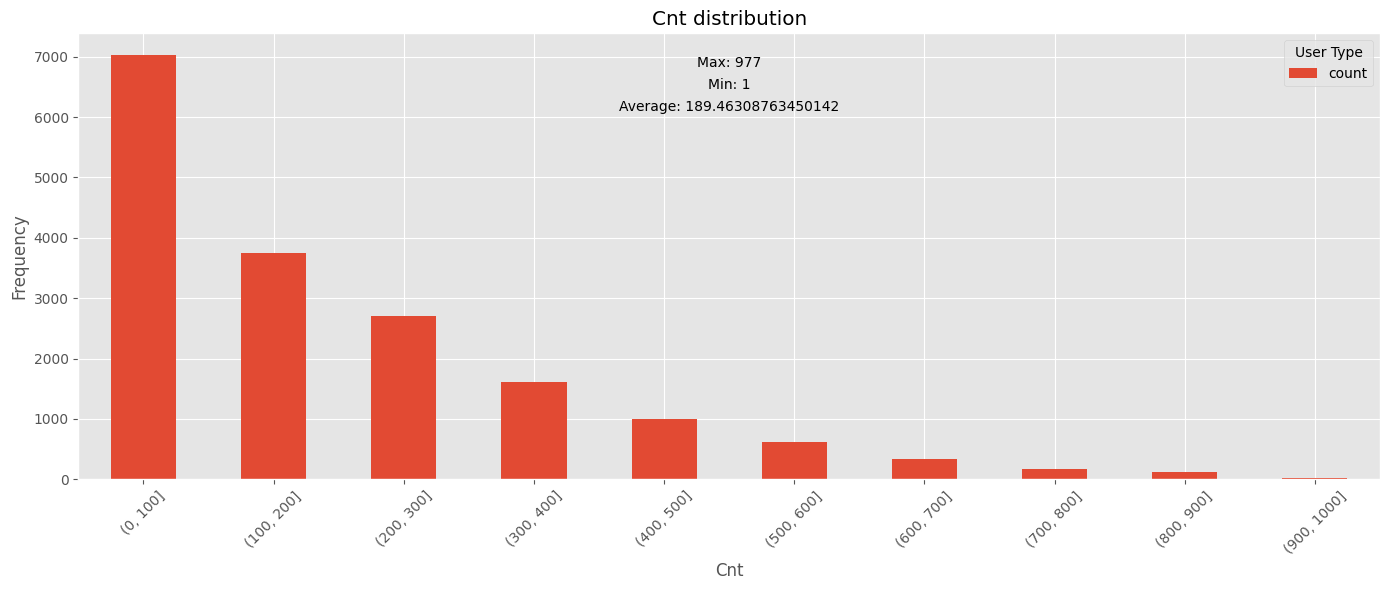

Distribution of weather types:
Clear/Few clouds       11413
Mist/Cloudy             4544
Light Snow/Rain         1419
Heavy Rain/Snow/Fog        3
Name: count, dtype: int64


In [6]:
# Distribution of target feature
bin_size = 100
data['cnt_bin'] = pandas.cut(data['cnt'], bins=range(0, data['cnt'].max() + bin_size, bin_size))
feature_data = data['cnt_bin'].value_counts().sort_index()

plt.figure(figsize=(14, 6))
feature_data.plot(kind='bar', ax=plt.gca())
plt.xlabel('Cnt')
plt.ylabel('Frequency')
plt.title('Cnt distribution')
plt.legend(title='User Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.text(0.5, 0.95, f'Max: {max(data["cnt"])}', ha='center', va='top', transform=plt.gca().transAxes)
plt.text(0.5, 0.90, f'Min: {min(data["cnt"])}', ha='center', va='top', transform=plt.gca().transAxes)
plt.text(0.5, 0.85, f'Average: {np.average(data["cnt"])}', ha='center', va='top', transform=plt.gca().transAxes)
plt.show()

# Distribution of each weather type
weather_desc = {
    1: 'Clear/Few clouds', 
    2: 'Mist/Cloudy', 
    3: 'Light Snow/Rain', 
    4: 'Heavy Rain/Snow/Fog'
}
weather_counts = data['weathersit'].value_counts().sort_index()
weather_counts.index = [weather_desc[i] for i in weather_counts.index]

print("Distribution of weather types:")
print(weather_counts)

### Temporal Analysis

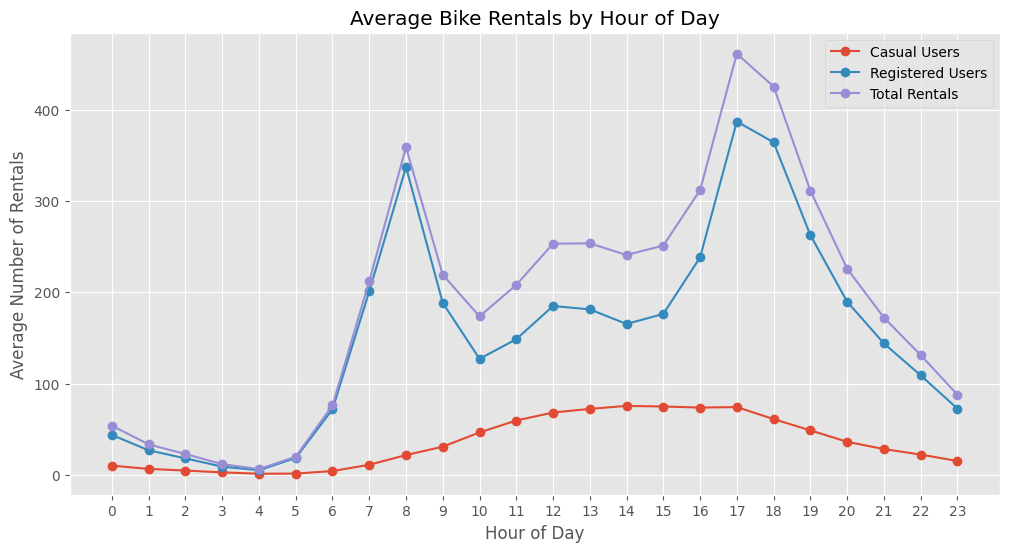

Numer of non-weekdays: 2502
Numer of weekdays: 2479


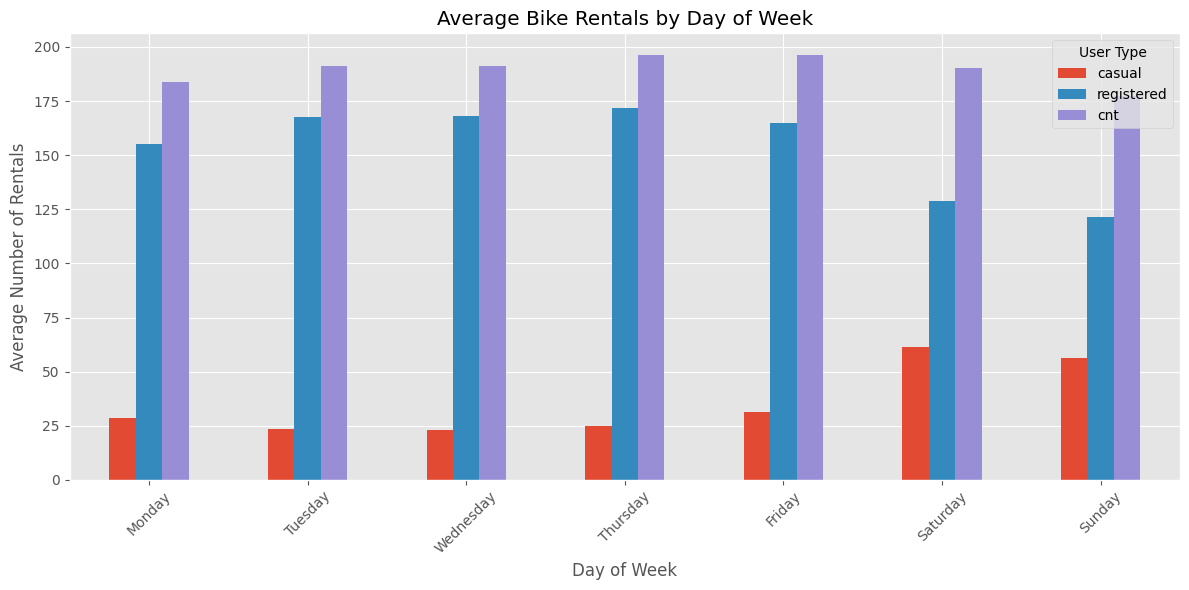

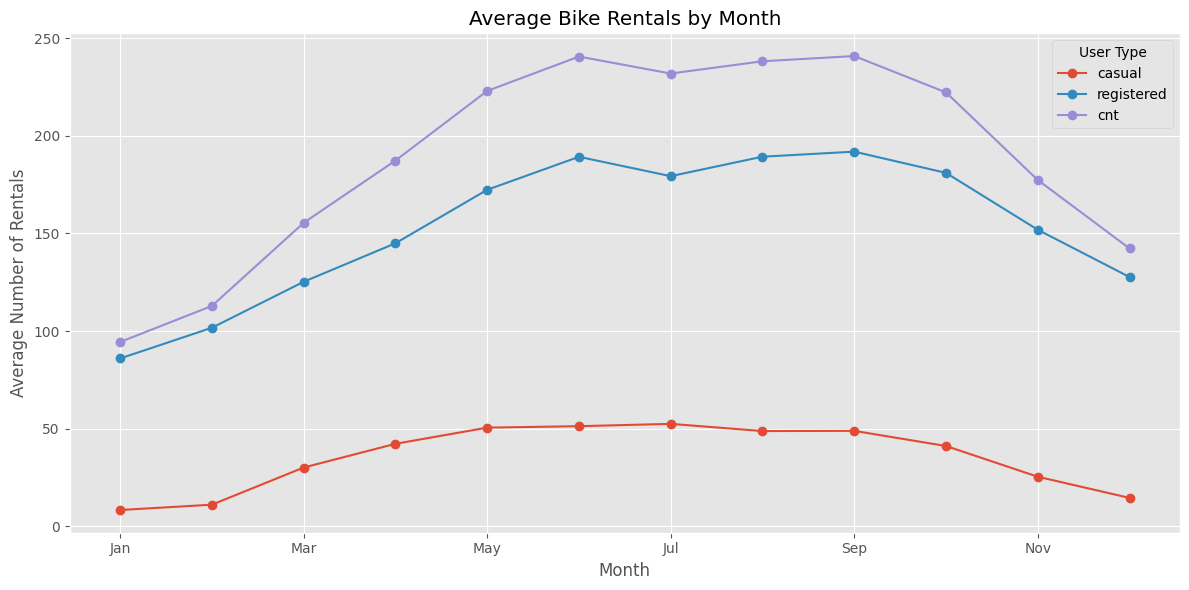

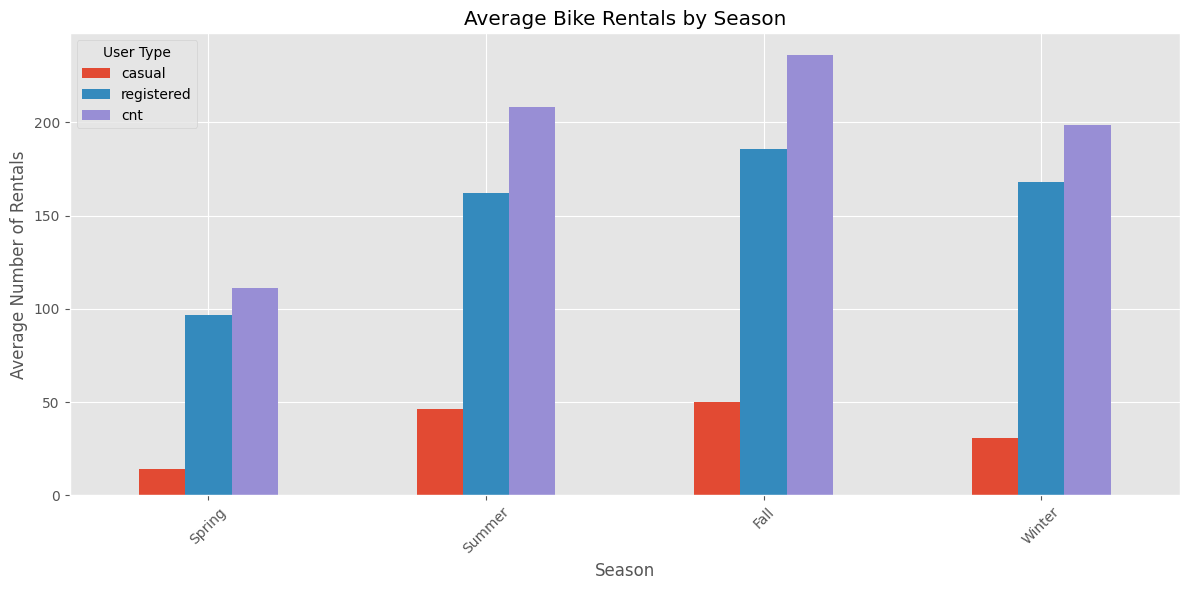

In [7]:
# HOURLY ANALYSIS
hourly_data = data.groupby('hr')[['casual', 'registered', 'cnt']].mean()
plt.figure(figsize=(12, 6))
plt.plot(hourly_data.index, hourly_data['casual'], 'o-', label='Casual Users')
plt.plot(hourly_data.index, hourly_data['registered'], 'o-', label='Registered Users')
plt.plot(hourly_data.index, hourly_data['cnt'], 'o-', label='Total Rentals')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Rentals')
plt.title('Average Bike Rentals by Hour of Day')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

# DAY OF WEEK ANALYSIS
weekday_names = {
    0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'
}
data['weekday_name'] = data['weekday'].map(weekday_names)
weekday_data = data.groupby('weekday_name')[['casual', 'registered', 'cnt']].mean()
weekday_data = weekday_data.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
print(f"Numer of non-weekdays: {data['weekday'].value_counts()[0]}")
print(f"Numer of weekdays: {data['weekday'].value_counts()[1]}")

plt.figure(figsize=(12, 6))
weekday_data.plot(kind='bar', ax=plt.gca())
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Rentals')
plt.title('Average Bike Rentals by Day of Week')
plt.legend(title='User Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# MONTHLY ANALYSIS
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
              7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
data['month_name'] = data['mnth'].map(month_names)
monthly_data = data.groupby('month_name')[['casual', 'registered', 'cnt']].mean()
monthly_data = monthly_data.reindex(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.figure(figsize=(12, 6))
monthly_data.plot(kind='line', marker='o', ax=plt.gca())
plt.xlabel('Month')
plt.ylabel('Average Number of Rentals')
plt.title('Average Bike Rentals by Month')
plt.legend(title='User Type')
plt.grid(True)
plt.tight_layout()
plt.show()

# SEASONAL ANALYSIS
season_names = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
data['season_name'] = data['season'].map(season_names)

seasonal_data = data.groupby('season_name')[['casual', 'registered', 'cnt']].mean()
# Reorder the index to follow seasonal order
seasonal_data = seasonal_data.reindex(['Spring', 'Summer', 'Fall', 'Winter'])

plt.figure(figsize=(12, 6))
seasonal_data.plot(kind='bar', ax=plt.gca())
plt.xlabel('Season')
plt.ylabel('Average Number of Rentals')
plt.title('Average Bike Rentals by Season')
plt.legend(title='User Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Binary Features Analysis

Numer of non-holidays: 16879
Numer of holidays: 500


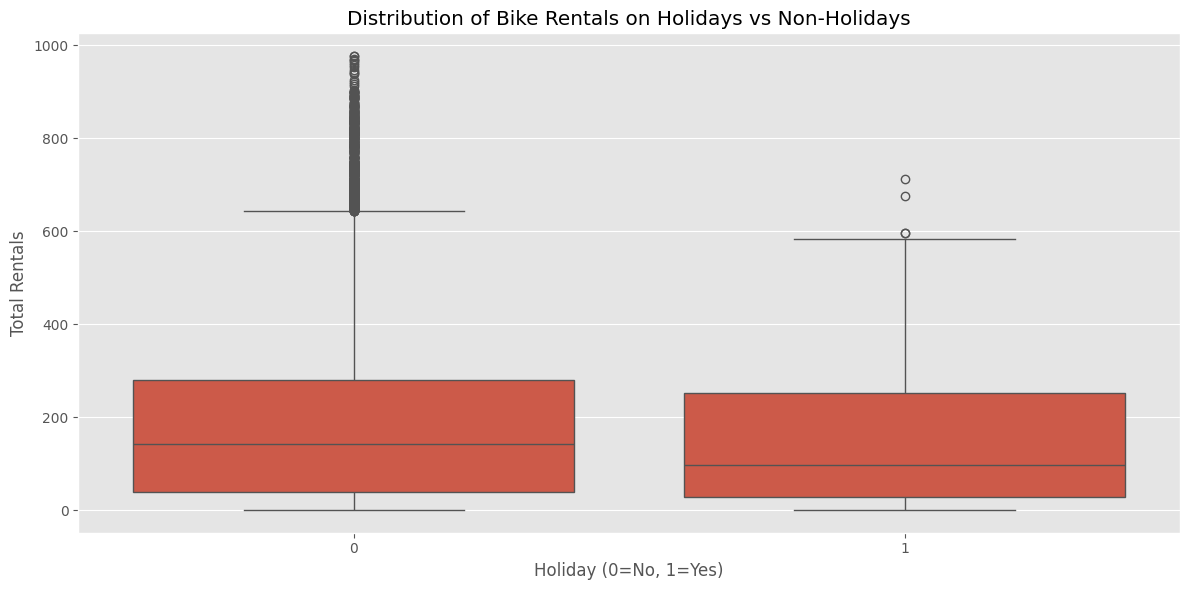

Numer of non-working days: 5514
Numer of working days: 11865


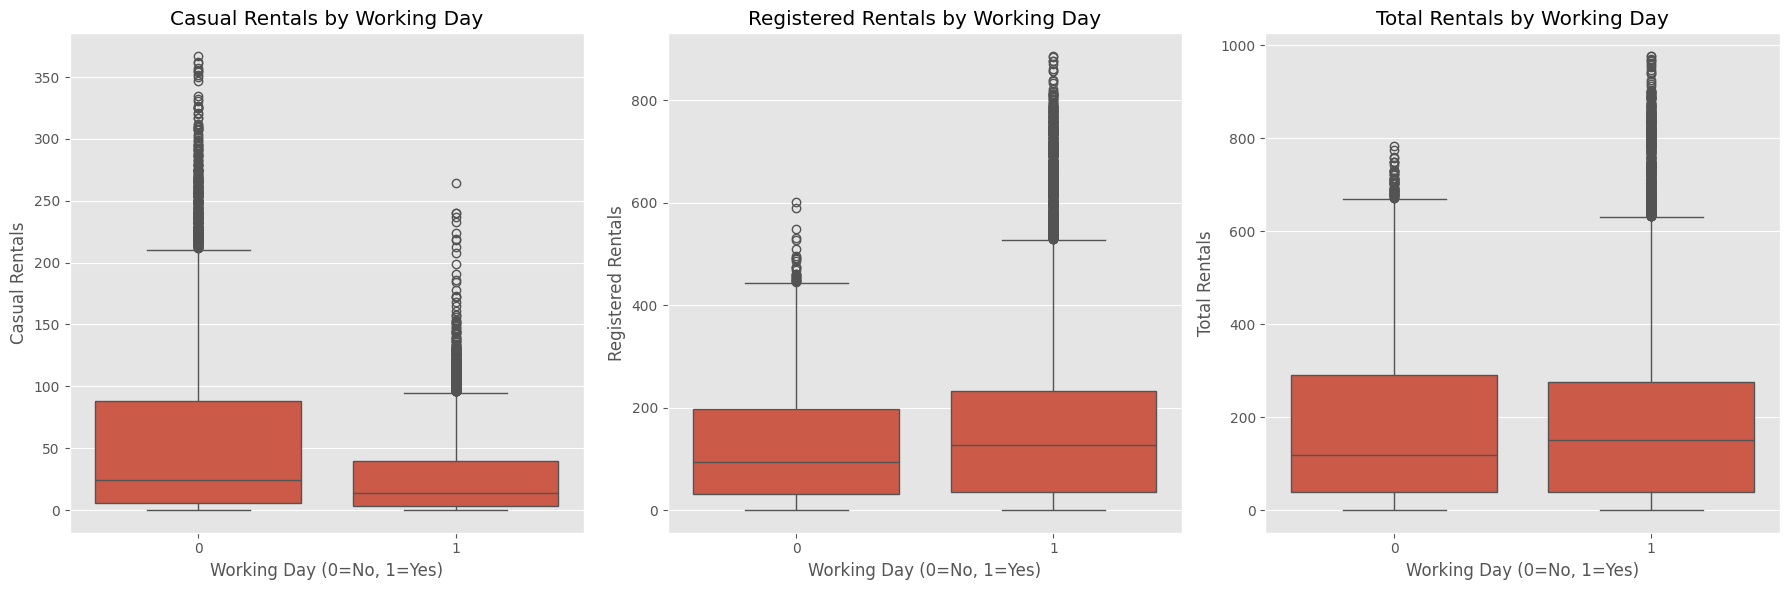

In [8]:
# HOLIDAY ANALYSIS

print(f"Numer of non-holidays: {data['holiday'].value_counts()[0]}")
print(f"Numer of holidays: {data['holiday'].value_counts()[1]}")
# This data imbalance might become problematic

plt.figure(figsize=(12, 6))
sns.boxplot(x='holiday', y='cnt', data=data)
plt.xlabel('Holiday (0=No, 1=Yes)')
plt.ylabel('Total Rentals')
plt.title('Distribution of Bike Rentals on Holidays vs Non-Holidays')
plt.tight_layout()
plt.show()


# WORKING DAY ANALYSIS

print(f"Numer of non-working days: {data['workingday'].value_counts()[0]}")
print(f"Numer of working days: {data['workingday'].value_counts()[1]}")
# This imbalance isn't too severe, but it's still important to keep in mind

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='workingday', y='casual', data=data, ax=axes[0])
axes[0].set_xlabel('Working Day (0=No, 1=Yes)')
axes[0].set_ylabel('Casual Rentals')
axes[0].set_title('Casual Rentals by Working Day')

sns.boxplot(x='workingday', y='registered', data=data, ax=axes[1])
axes[1].set_xlabel('Working Day (0=No, 1=Yes)')
axes[1].set_ylabel('Registered Rentals')
axes[1].set_title('Registered Rentals by Working Day')

sns.boxplot(x='workingday', y='cnt', data=data, ax=axes[2])
axes[2].set_xlabel('Working Day (0=No, 1=Yes)')
axes[2].set_ylabel('Total Rentals')
axes[2].set_title('Total Rentals by Working Day')

plt.tight_layout()
plt.show()

### Weather Features Analysis

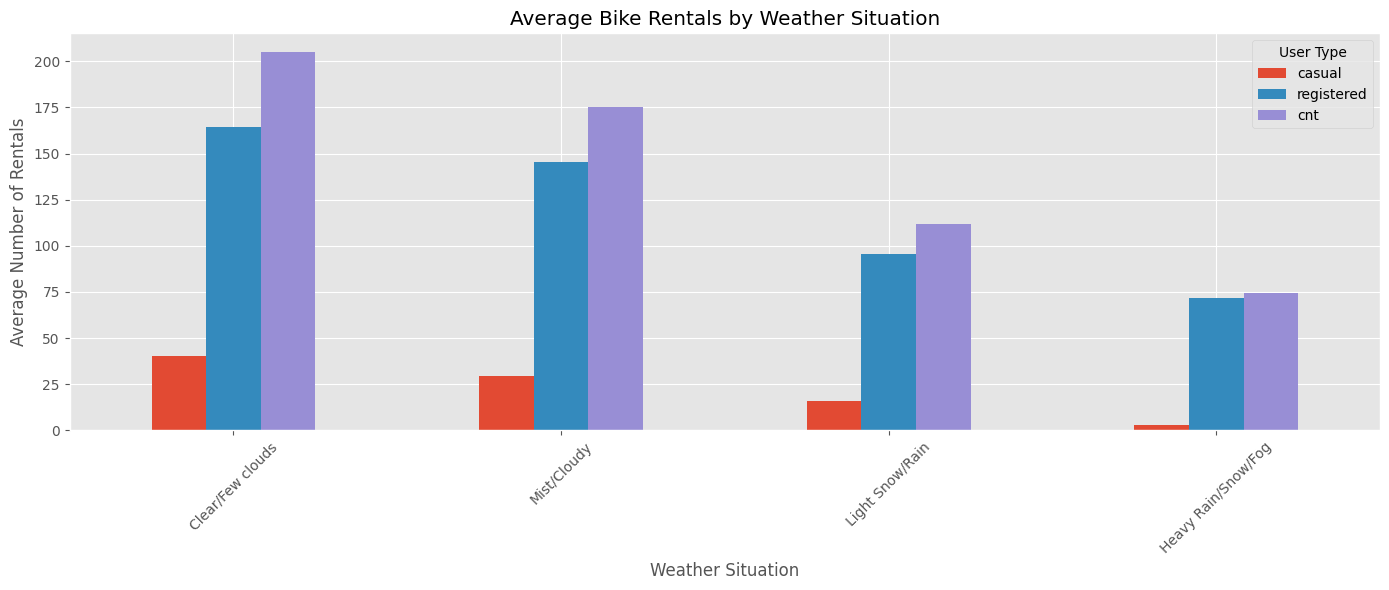

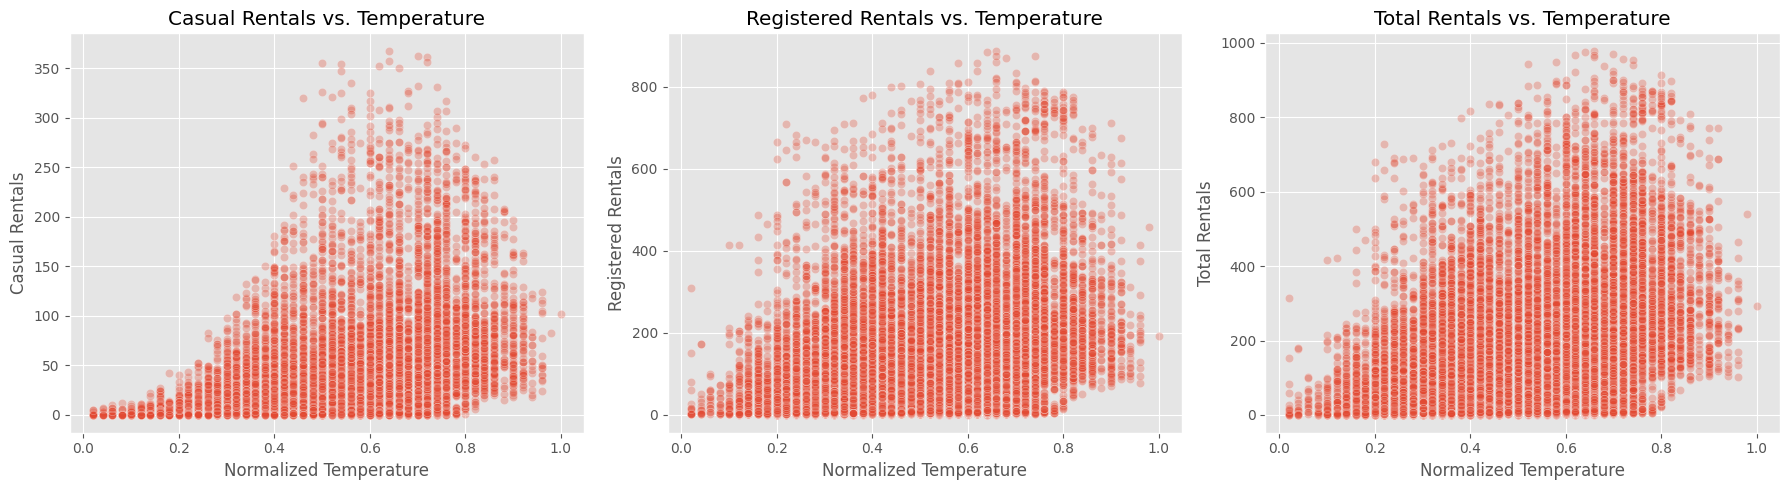

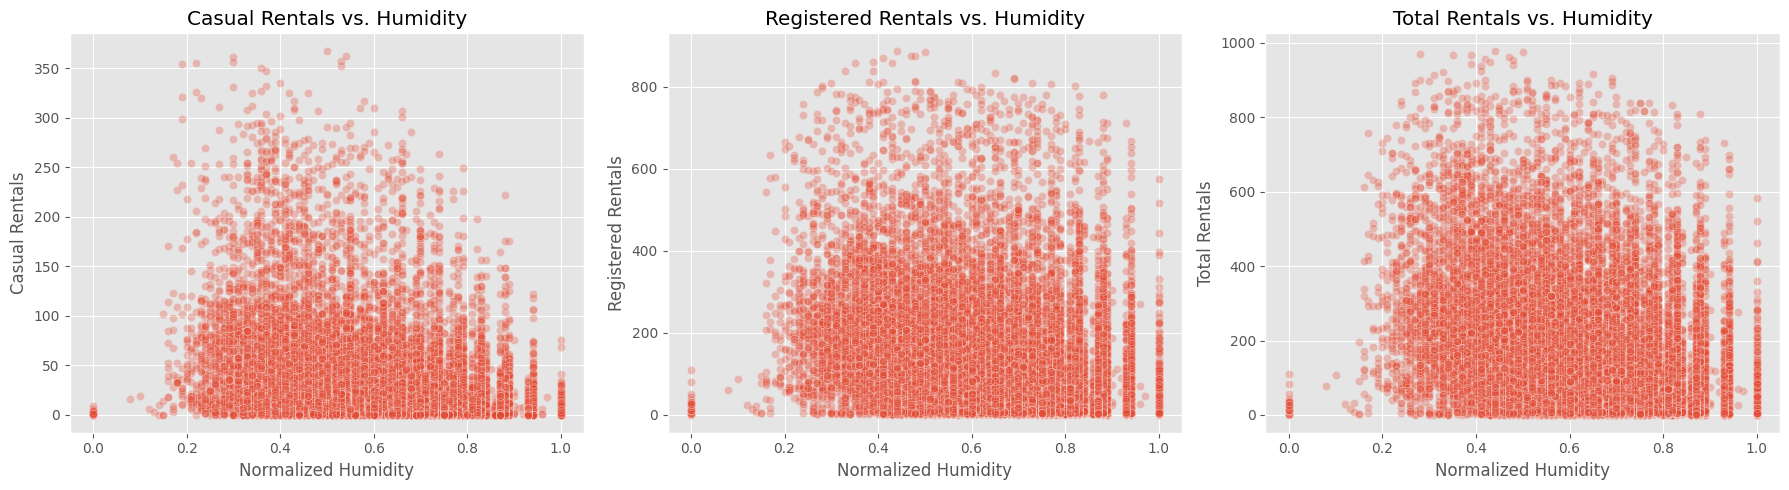

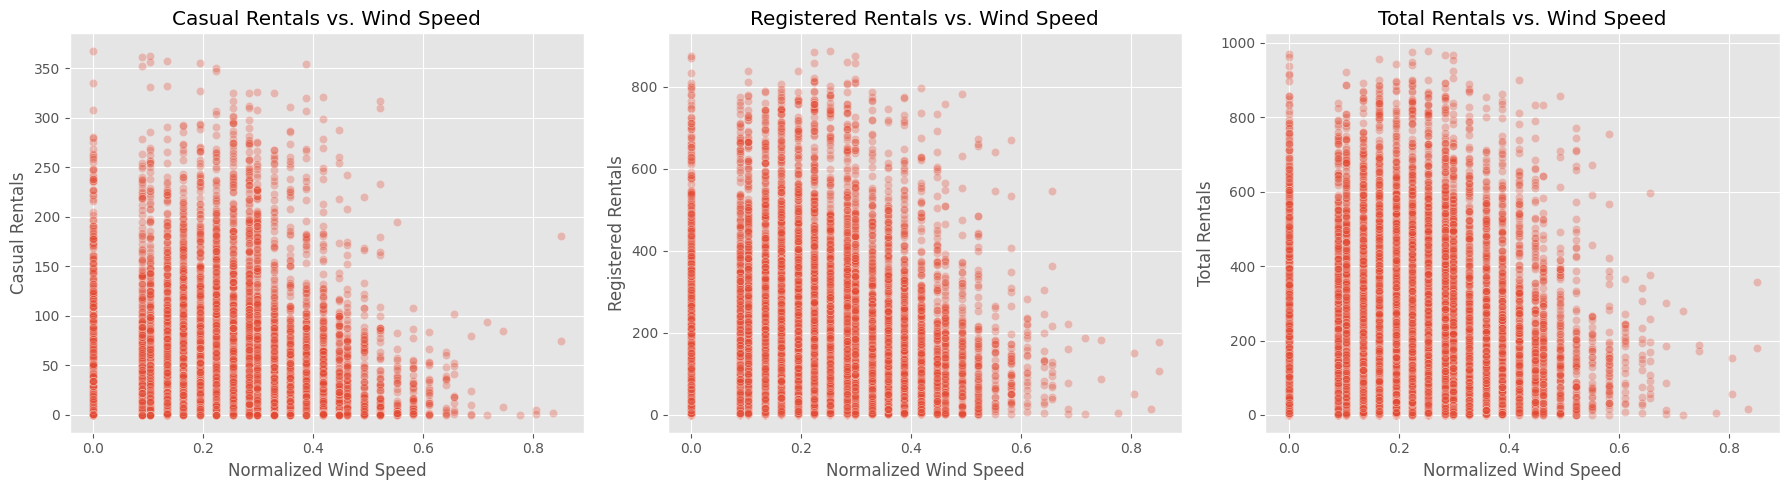

Correlation between temp and atemp: 0.9877 (p-value: 0.0000)


In [9]:

# WEATHER TYPE ANALYSIS
weather_data = data.groupby('weathersit')[['casual', 'registered', 'cnt']].mean()
weather_desc = {
    1: 'Clear/Few clouds', 
    2: 'Mist/Cloudy', 
    3: 'Light Snow/Rain', 
    4: 'Heavy Rain/Snow/Fog'
}
weather_data.index = [weather_desc[i] for i in weather_data.index]

plt.figure(figsize=(14, 6))
weather_data.plot(kind='bar', ax=plt.gca())
plt.xlabel('Weather Situation')
plt.ylabel('Average Number of Rentals')
plt.title('Average Bike Rentals by Weather Situation')
plt.legend(title='User Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# TEMPERATURE ANALYSIS
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.scatterplot(x='temp', y='casual', data=data, alpha=0.3, ax=axes[0])
axes[0].set_xlabel('Normalized Temperature')
axes[0].set_ylabel('Casual Rentals')
axes[0].set_title('Casual Rentals vs. Temperature')

sns.scatterplot(x='temp', y='registered', data=data, alpha=0.3, ax=axes[1])
axes[1].set_xlabel('Normalized Temperature')
axes[1].set_ylabel('Registered Rentals')
axes[1].set_title('Registered Rentals vs. Temperature')

sns.scatterplot(x='temp', y='cnt', data=data, alpha=0.3, ax=axes[2])
axes[2].set_xlabel('Normalized Temperature')
axes[2].set_ylabel('Total Rentals')
axes[2].set_title('Total Rentals vs. Temperature')

plt.tight_layout()
plt.show()

# HUMIDITY ANALYSIS
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.scatterplot(x='hum', y='casual', data=data, alpha=0.3, ax=axes[0])
axes[0].set_xlabel('Normalized Humidity')
axes[0].set_ylabel('Casual Rentals')
axes[0].set_title('Casual Rentals vs. Humidity')

sns.scatterplot(x='hum', y='registered', data=data, alpha=0.3, ax=axes[1])
axes[1].set_xlabel('Normalized Humidity')
axes[1].set_ylabel('Registered Rentals')
axes[1].set_title('Registered Rentals vs. Humidity')

sns.scatterplot(x='hum', y='cnt', data=data, alpha=0.3, ax=axes[2])
axes[2].set_xlabel('Normalized Humidity')
axes[2].set_ylabel('Total Rentals')
axes[2].set_title('Total Rentals vs. Humidity')

plt.tight_layout()
plt.show()

# WIND SPEED ANALYSIS
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.scatterplot(x='windspeed', y='casual', data=data, alpha=0.3, ax=axes[0])
axes[0].set_xlabel('Normalized Wind Speed')
axes[0].set_ylabel('Casual Rentals')
axes[0].set_title('Casual Rentals vs. Wind Speed')

sns.scatterplot(x='windspeed', y='registered', data=data, alpha=0.3, ax=axes[1])
axes[1].set_xlabel('Normalized Wind Speed')
axes[1].set_ylabel('Registered Rentals')
axes[1].set_title('Registered Rentals vs. Wind Speed')

sns.scatterplot(x='windspeed', y='cnt', data=data, alpha=0.3, ax=axes[2])
axes[2].set_xlabel('Normalized Wind Speed')
axes[2].set_ylabel('Total Rentals')
axes[2].set_title('Total Rentals vs. Wind Speed')

plt.tight_layout()
plt.show()

# CORRELATION BETWEEN TEMP AND ATEMPT
# Let's check for collinearity to remove redundant features
corr, p_value = pearsonr(data['temp'], data['atemp'])
print(f"Correlation between temp and atemp: {corr:.4f} (p-value: {p_value:.4f})")

### EDA Conclusion

Before we can start with model training, lets remove some useless columns.
>- instant: This is just an index and serves no use.
>- dteday: As described earlier, this is the only non-numerical feature. Since the creators have already split this feature into season, year, month and hour, and enhanced it with holiday, weekday and workingday, we no longer need this column.
>- The casual and registered features are cnt, our target feature, split into two types. If our model trains off these columns this will obviously introduce data leakage, and we should therefore remove it.
>- Also, I added some dummy columns to assit with data visualization which we should also remove.
>- Finally, the last thing we checked for was the collinearity between temp and atemp, which I found to be 0.9877. Since these are highly correlated, and therefore reducant, lets remove atemp.

From the EDA, I was surprised to find the following relationships (and lack thereof):
>- The temporal features are all informative, except for days of the week. The number of rentals stays relativley concistent across the different days of the week, including weekends.
>- Surprisingly, the binary features do not have a large affect on the distribution of cnt. The core distribution of cnt under each binary feature does not change much (by core I mean the middle 75% of the data), only the number of outliers tends to change with working days and holidays. A large issue I found here, however, is the large class imbalance present the 'holiday' column. There were only 500 holidays, and 16,789 non-holidays. This leads me to believe the relationship deduced from this feature isn't very accurate, and I should either drop this column or address this imbalance later on.
>- The weather features lined up with my expectations pretty well. This is a large correlation between weather type and cnt, and a moderate correlation between windspeed and temperature with cnt. As predicted, humidity has a very limited affect on cnt. 

Alarmingly, there is a lot of class imbalance present in the dataset. The target feature itself is very strongly rightly skewed, with >7k hours when only 0-100 bikes were rented and less than 100 hours when 900-1000 bikes were rented. For this I will:
>- I can log transform the target to compress the long tail. This should help with inference of higher values of 'cnt'
>- I can reweight samples. When training my models, I can give a higher weight to higher 'cnt' samples, although this may hurt performance on low-rental days.

Also, the weather types are very imabalced, with only 3 hours when the weather was very bad. For this I will:
>- 3 samples is much too little to have any meaning. I will merge weather types 3 and 4.


In [10]:
data.drop(columns=['instant', 'dteday', 'casual', 'registered', 'weekday_name', 'season_name', 'month_name', 'atemp', 'cnt_bin'], inplace=True)
pre_split_data = data.copy()
pre_split_data.info()
pre_split_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  int64  
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  int64  
 5   weekday     17379 non-null  int64  
 6   workingday  17379 non-null  int64  
 7   weathersit  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   hum         17379 non-null  float64
 10  windspeed   17379 non-null  float64
 11  cnt         17379 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 1.6 MB


season  yr  mnth  hr  holiday  weekday  workingday  weathersit  temp   hum  \
0       1   0     1   0        0        6           0           1  0.24  0.81   
1       1   0     1   1        0        6           0           1  0.22  0.80   
2       1   0     1   2        0        6           0           1  0.22  0.80   
3       1   0     1   3        0        6           0           1  0.24  0.75   
4       1   0     1   4        0        6           0           1  0.24  0.75   

   windspeed  cnt  
0        0.0   16  
1        0.0   40  
2        0.0   32  
3        0.0   13  
4        0.0    1

# Task 2: Data Splitting

Now lets split our dataset into training (60%), testing (20%) and validation (20%) sets. Imporantly, we should ensure all entries maintain their chronological order, ensuring that we don't end up trying to predict past events with future data (data leakage!)

I actually had to re-do this part. At first I incorporated no randomness, and just sorted the data by their chronological order and split it that way. Then I thought about splitting up the data into temporal blocks (eg. one month) and randomly shuffling these around, however that of course will lead to data leakage. Instead, I identified what I think is a good option:
>- Still sort the data chronologically and split it accordingly, so the training set contains the first 60% of data and so on. Then, split the training set into temporal blocks of one month and shuffle these around. This way the model is trained off of semi-randomly distrubted data, and the validation and test sets are still in the future.

In [11]:
data_sorted = pre_split_data.sort_values(by=['yr', 'mnth', 'hr'])

# Calculate split indices
n = len(data_sorted)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

# Split the data
train_data = data_sorted.iloc[:train_end]
val_data = data_sorted.iloc[train_end:val_end]
test_data = data_sorted.iloc[val_end:]

# Split train_data into monthly blocks
train_data['month'] = train_data['mnth']
monthly_groups = train_data.groupby('month')

# Shuffle the monthly groups
shuffled_train_data = monthly_groups.apply(lambda x: x.sample(frac=1)).reset_index(drop=True)

# Separate features and target
X_train = shuffled_train_data.drop(columns=['cnt', 'month'])
y_train = shuffled_train_data['cnt'] #forgot to shuffle here...

y_val = val_data['cnt']
X_val = val_data.drop(columns=['cnt'])

y_test = test_data['cnt']
X_test = test_data.drop(columns=['cnt'])


print(f"Data split complete:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/n:.1%})")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/n:.1%})")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/n:.1%})\n")
print(X_train.info())

Data split complete:
Training set: 10427 samples (60.0%)
Validation set: 3476 samples (20.0%)
Test set: 3476 samples (20.0%)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10427 entries, 0 to 10426
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10427 non-null  int64  
 1   yr          10427 non-null  int64  
 2   mnth        10427 non-null  int64  
 3   hr          10427 non-null  int64  
 4   holiday     10427 non-null  int64  
 5   weekday     10427 non-null  int64  
 6   workingday  10427 non-null  int64  
 7   weathersit  10427 non-null  int64  
 8   temp        10427 non-null  float64
 9   hum         10427 non-null  float64
 10  windspeed   10427 non-null  float64
dtypes: float64(3), int64(8)
memory usage: 896.2 KB
None


/var/folders/9s/vy9f4h3s1zx18jv8p3n1b6gh0000gn/T/ipykernel_67708/360144730.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['month'] = train_data['mnth']


# Task 3: Feature Engineering

First, lets encode cyclical features (hr, weekday) using sine and cosine transforms

Also, lets combine weather type 4 and 3 before we one-hot encode them.

These transformations should be applied to all sets: train, val, test

In [12]:
def cyclical_encoding(df, col, period):
    """Apply sine and cosine encoding to cyclical features."""
    # Calculate sine and cosine transformations
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / period)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / period)
    return df

# Apply cyclical encoding to hour (period=24) and weekday (period=7)
for df in [X_train, X_val, X_test]:
    cyclical_encoding(df, 'hr', 24)
    cyclical_encoding(df, 'weekday', 7)

# Lets merge weather types 3 and 4
X_train['weathersit'] = X_train['weathersit'].replace(4, 3)
X_val['weathersit'] = X_val['weathersit'].replace(4, 3)
X_test['weathersit'] = X_test['weathersit'].replace(4, 3)
print(X_train['weathersit'].value_counts())


weathersit
1    6779
2    2715
3     933
Name: count, dtype: int64


Now, let's One-hot encode the categorical variables

Categorical variables to encode: season, weathersit, mnth

In [13]:
cat_features = ['season', 'weathersit', 'mnth']

# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, drop='first')

ohe.fit(X_train[cat_features])

# Transform all datasets
train_encoded = ohe.transform(X_train[cat_features])
val_encoded = ohe.transform(X_val[cat_features])
test_encoded = ohe.transform(X_test[cat_features])

# Create dataframes with encoded features
ohe_feature_names = ohe.get_feature_names_out(cat_features)
train_encoded_df = pandas.DataFrame(train_encoded, columns=ohe_feature_names, index=X_train.index)
val_encoded_df = pandas.DataFrame(val_encoded, columns=ohe_feature_names, index=X_val.index)
test_encoded_df = pandas.DataFrame(test_encoded, columns=ohe_feature_names, index=X_test.index)

# Drop the original categorical columns and add the encoded ones
X_train = X_train.drop(columns=cat_features).join(train_encoded_df)
X_val = X_val.drop(columns=cat_features).join(val_encoded_df)
X_test = X_test.drop(columns=cat_features).join(test_encoded_df)

# Now we can drop the original cyclical columns since we've encoded them
X_train = X_train.drop(columns=['hr', 'weekday'])
X_val = X_val.drop(columns=['hr', 'weekday'])
X_test = X_test.drop(columns=['hr', 'weekday'])

Before we can consider the data ready for modeling, we should apply scaling to the continious features, which are: temp, atemp (dropped), hum and windspeed.

As I pointed out in the EDA, the creators of the dataset normalized these features, which will likley be determintal to the performance of our Linear Regression model. Luckily, they specified with what values they normalized these features by so we can reverse-engineer this, and then apply scaling.

Specifically:
>- temp: values divided by 41 (their max)
>- hum: values divided by 100 (max)
>- windspeed: values divided by 67

In [14]:
# Reverse the normalization
X_train['temp'] = X_train['temp'] * 41
X_val['temp'] = X_val['temp'] * 41
X_test['temp'] = X_test['temp'] * 41

X_train['hum'] = X_train['hum'] * 100
X_val['hum'] = X_val['hum'] * 100
X_test['hum'] = X_test['hum'] * 100

X_train['windspeed'] = X_train['windspeed'] * 67
X_val['windspeed'] = X_val['windspeed'] * 67
X_test['windspeed'] = X_test['windspeed'] * 67


# Standardize numeric features
numeric_cols = ['temp', 'hum', 'windspeed']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])




print("\nFeature engineering complete.")
print(f"Training features: {X_train.shape[1]} features")
print("Feature names:", X_train.columns.tolist())

print("\nFinal preprocessed data:")
print(X_train.head())
print(X_train.info())


Feature engineering complete.
Training features: 26 features
Feature names: ['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'hr_sin', 'hr_cos', 'weekday_sin', 'weekday_cos', 'season_2', 'season_3', 'season_4', 'weathersit_2', 'weathersit_3', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12']

Final preprocessed data:
   yr  holiday  workingday      temp       hum  windspeed    hr_sin    hr_cos  \
0   1        0           0 -1.418616  0.524266   0.839914 -0.500000  0.866025   
1   0        0           0 -1.215509  0.828198  -1.556423  0.258819  0.965926   
2   1        0           1 -1.012401 -0.184909   0.000996  0.965926 -0.258819   
3   1        0           1 -1.012401 -0.792773  -0.478272  0.500000  0.866025   
4   1        0           1 -0.809294 -1.552603   1.559217 -0.500000 -0.866025   

   weekday_sin  weekday_cos  ...  mnth_3  mnth_4  mnth_5  mnth_6  mnth_7  \
0    -0.781831     0.623490  ...     0.0   

# Tasks 4 - 7: Initial Model Training + Analysis

## Baseline Model - Linear Regression

Now our data is ready to train our Linear Regression model. Let's train it and analyze it's performance on the validation set


===== Linear Regression Results =====
Mean Squared Error (MSE): 27540.74
Root Mean Squared Error (RMSE): 165.95
Mean Absolute Error (MAE): 128.70
R² Score: 0.3955


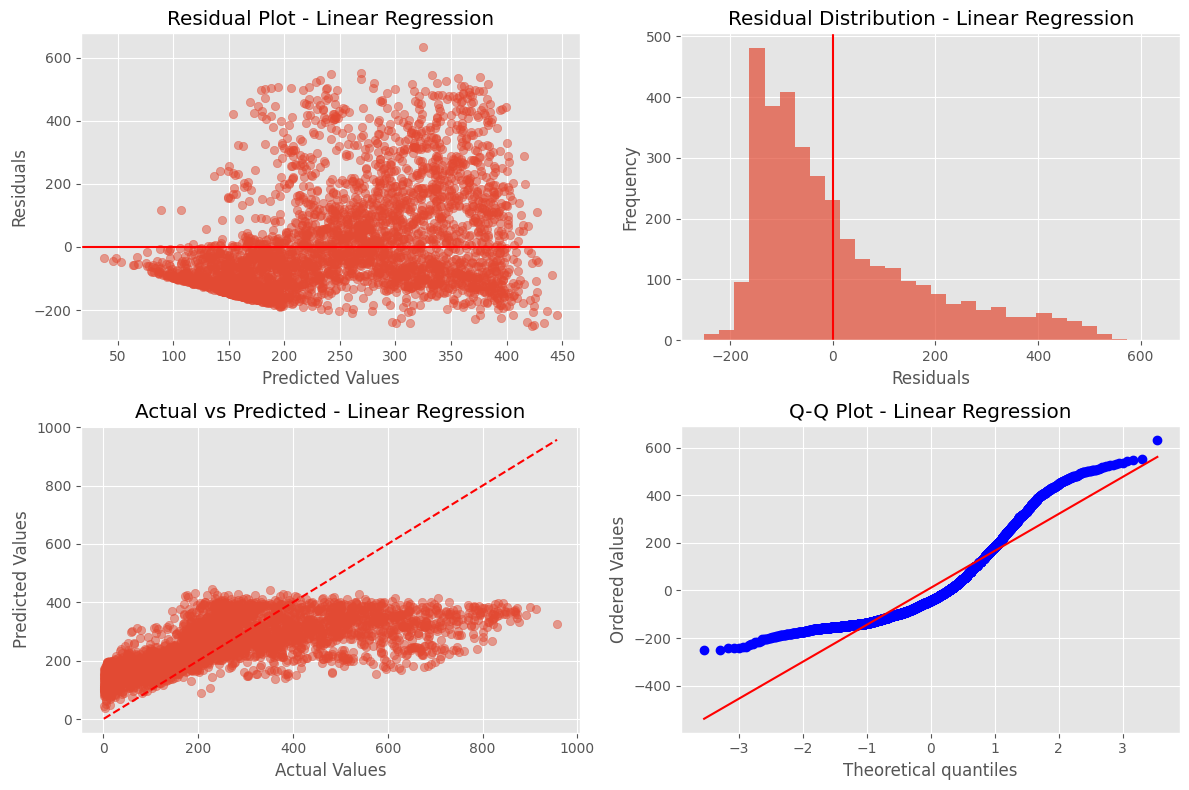

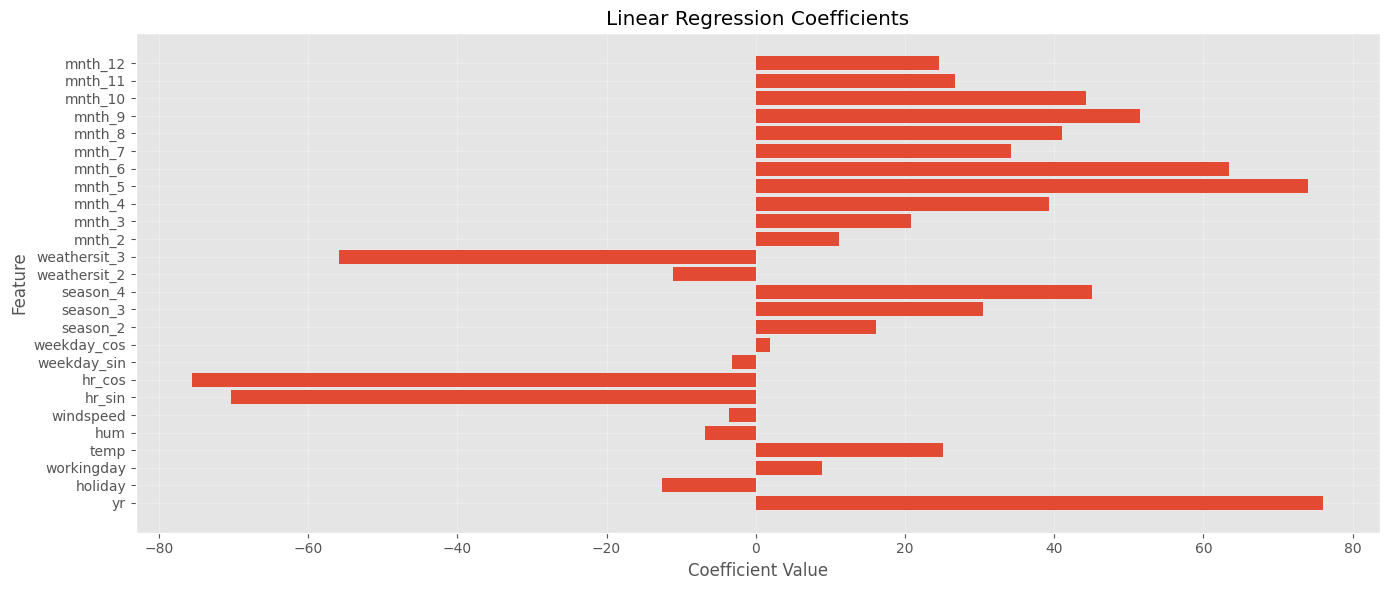

In [15]:
# train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# predict on validation set
y_val_pred_lr = lr_model.predict(X_val)

lr_mse = mean_squared_error(y_val, y_val_pred_lr)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_val, y_val_pred_lr)
lr_r2 = r2_score(y_val, y_val_pred_lr)

print("\n===== Linear Regression Results =====")
print(f"Mean Squared Error (MSE): {lr_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {lr_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {lr_mae:.2f}")
print(f"R² Score: {lr_r2:.4f}")

# Plot residuals
residuals_lr = y_val - y_val_pred_lr

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(y_val_pred_lr, residuals_lr, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - Linear Regression')

# Histogram of residuals
plt.subplot(2, 2, 2)
plt.hist(residuals_lr, bins=30, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='-')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution - Linear Regression')

# Actual vs Predicted
plt.subplot(2, 2, 3)
plt.scatter(y_val, y_val_pred_lr, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted - Linear Regression')

# QQ plot for residuals
plt.subplot(2, 2, 4)
from scipy import stats
stats.probplot(residuals_lr, dist="norm", plot=plt)
plt.title('Q-Q Plot - Linear Regression')

plt.tight_layout()
plt.show()

# Plot coefficients
feature_names = X_train.columns
coefficients = lr_model.coef_

plt.figure(figsize=(14, 6))
plt.barh(feature_names, coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Linear Regression Coefficients')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

As we can see, this model performed very poorly. 

The values for MSE and RMSE, 275.40 and 165.95 respectivley, show that the model poorly predicts the target feature. In fact, the model is off by about 165 users on average, and when you consider the fact that the average value of 'CNT' in the dataset is ~189 this is pretty bad. Also, it has an R^2 score of 0.4, meaning the model actually does worse than just predicting the mean of 'cnt'.

The distribution of residuals also tells us that the model is systematically underpredicting our target feature, due to the left skew present in the histogram. 

Another alarming insight can be found in the Actual vs Predicted plot. In the ideal case each point (prediction) would be clustered tightly along the red line, representing accurate predictions. However, our predictions perform well for low values of the target feature, but poorly for large values.

A good sign, however, can be found in the Q-Q plot. Since many points fall along the red line (other than the tails, although this is apparently 'okay' in read-world data), this tells us that the residuals are roughly normally distributed. Normality of residuals is one of the core assumptions of linear regression, which affects inference and hypothesis testing (although not prediction accuracy as much). What this tells us is that although the model is concistently wrong, the errors it makes are symmetrical and normally distriubted and therefore the model is not dominated by outliers. 

This may indiciate a couple things:
>- The data has non-linear relationships, making it unsuitable for linear regression.
>- The data may have interactions and/or irrelevant features. 

I could try introducing some interaction terms to help the model, but I think the issue lies in the model that we're using. I think many important relationships aren't actually linear, which is my linear regression is struggling. Let's try some more flexible models, Random Forest and Gradient Boosting, which do not assume linearity.

## Random Forest Regressor


===== Random Forest Regressor Results =====
Mean Squared Error (MSE): 13259.53
Root Mean Squared Error (RMSE): 115.15
Mean Absolute Error (MAE): 80.56
R² Score: 0.7090

Training MSE: 172.21, Validation MSE: 13259.53
Training R²: 0.9904, Validation R²: 0.7090


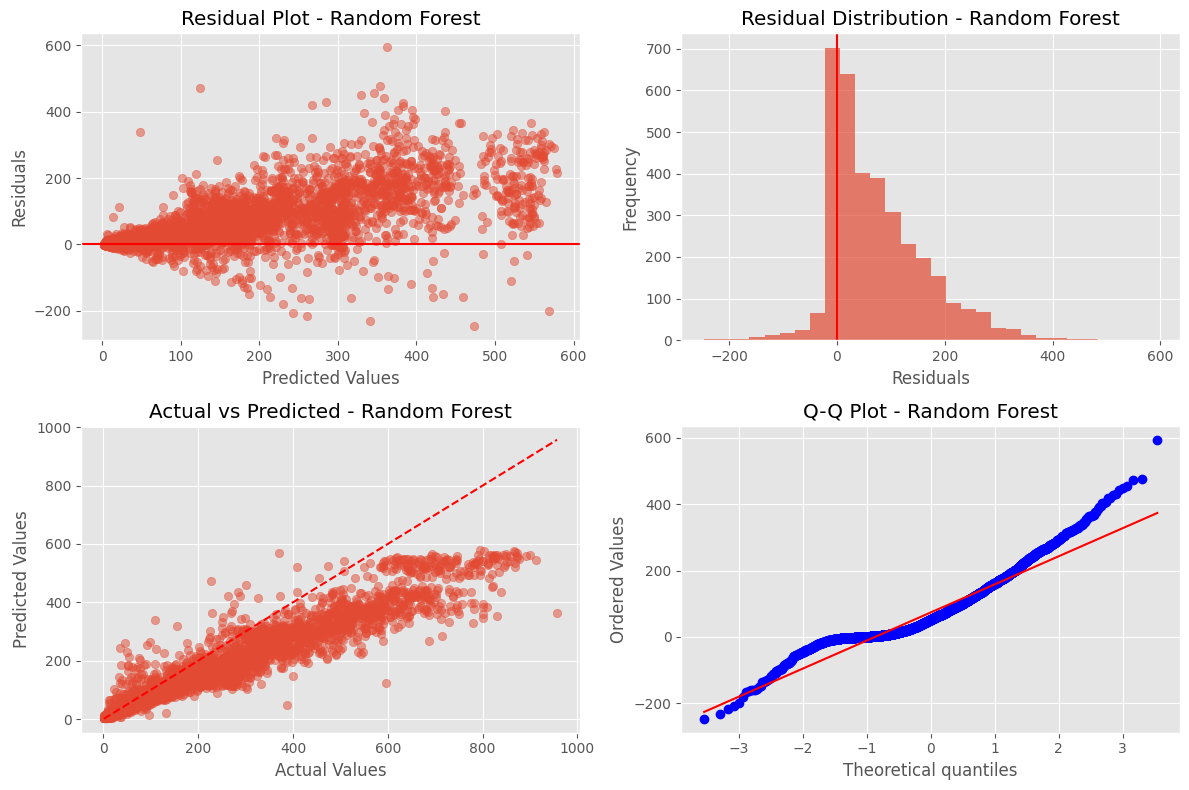

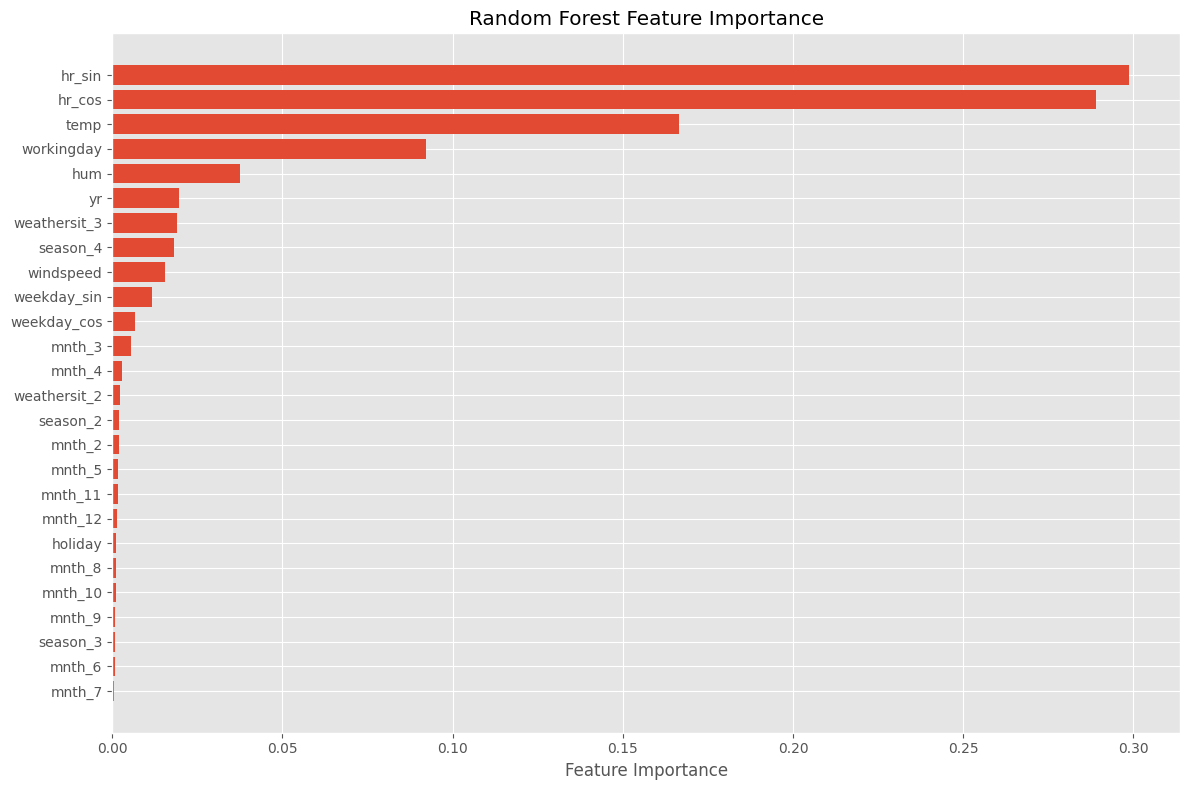

In [16]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on validation set
y_val_pred_rf = rf_model.predict(X_val)

rf_mse = mean_squared_error(y_val, y_val_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_val, y_val_pred_rf)
rf_r2 = r2_score(y_val, y_val_pred_rf)

# Overfit check; predict on training set
y_train_pred_rf = rf_model.predict(X_train)
train_mse_rf = mean_squared_error(y_train, y_train_pred_rf)
train_r2_rf = r2_score(y_train, y_train_pred_rf)



print("\n===== Random Forest Regressor Results =====")
print(f"Mean Squared Error (MSE): {rf_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rf_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {rf_mae:.2f}")
print(f"R² Score: {rf_r2:.4f}\n")
print(f"Training MSE: {train_mse_rf:.2f}, Validation MSE: {rf_mse:.2f}")
print(f"Training R²: {train_r2_rf:.4f}, Validation R²: {rf_r2:.4f}")

if train_r2_rf - rf_r2 > 0.05:
    print("Warning: Overfitting detected. Try reducing tree depth or increasing min_samples_leaf.")
else:
    print("Model generalizes well.")

# Plot residuals
residuals_rf = y_val - y_val_pred_rf

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(y_val_pred_rf, residuals_rf, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - Random Forest')

# Histogram of residuals
plt.subplot(2, 2, 2)
plt.hist(residuals_rf, bins=30, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='-')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution - Random Forest')

# Actual vs Predicted
plt.subplot(2, 2, 3)
plt.scatter(y_val, y_val_pred_rf, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted - Random Forest')

# QQ plot for residuals
plt.subplot(2, 2, 4)
stats.probplot(residuals_rf, dist="norm", plot=plt)
plt.title('Q-Q Plot - Random Forest')

plt.tight_layout()
plt.show()

# Feature importance plot
feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(12, 8))
plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()


As we can see, this model performed way better.

The values for MSE and RMSE, 13377 and 115 respectivley, show that the model still poorly predicts the target feature but much better than before. Also, it also has an R^2 score of 0.7064, which is way better than with Linear Regression.

Also, when checking for overfitting we can obviously tell that the model performs much better on seen data. It fails to generalize to the validation set, and performs very well on its training set (R^2 value of 0.9902). This can be fixed with hyperparameter tuning (limiting tree depth, increasing min_samples_leaf, etc.), which will be done in task 7. 

The plot of residuals fan out in the positive direction, telling us that the model is systematically underpredicting at higher values of 'cnt'. 

The distribution of residuals is skewed right, but it seems close to normal. This indicates again that high-value targets are underpredicted. This distribution, however, does look slightly better than with the linear regression model. Although it isn't quite normally distributed, which isn't essential for Random Forest although it is a sign of imbalance in the model's predictive capabilities, it does have slightly less of a right skew than with the Linear Regression model. 

The actual vs predicted plot is again indivating that the model fails to predict high values, although it's variance is much higher than with the baseline model. This tells me that the model was able to capture more meaningful relationships in the data than with linear regression, as its not as clustered around the value of ~200. 

Again, to improve this model I could introduce an interaction term into the dataset. Although RF can capture these on its own, explicit interactions can still help in weakly informative features. Since the features mnth_x aren't doing much, I could try introducing an interaction term comparing the month and average temperature or weather type (making the summer months more predictive). I also think the model is missing a lot of inference with the weather features, due to the class imbalance, so I could try addressing that as well.

## Gradient Boosting Regressor


===== Gradient Boosting Regressor Results =====
Mean Squared Error (MSE): 15078.56
Root Mean Squared Error (RMSE): 122.79
Mean Absolute Error (MAE): 87.20
R² Score: 0.6691

Training MSE: 2361.76, Validation MSE: 15078.56
Training R²: 0.8683, Validation R²: 0.6691


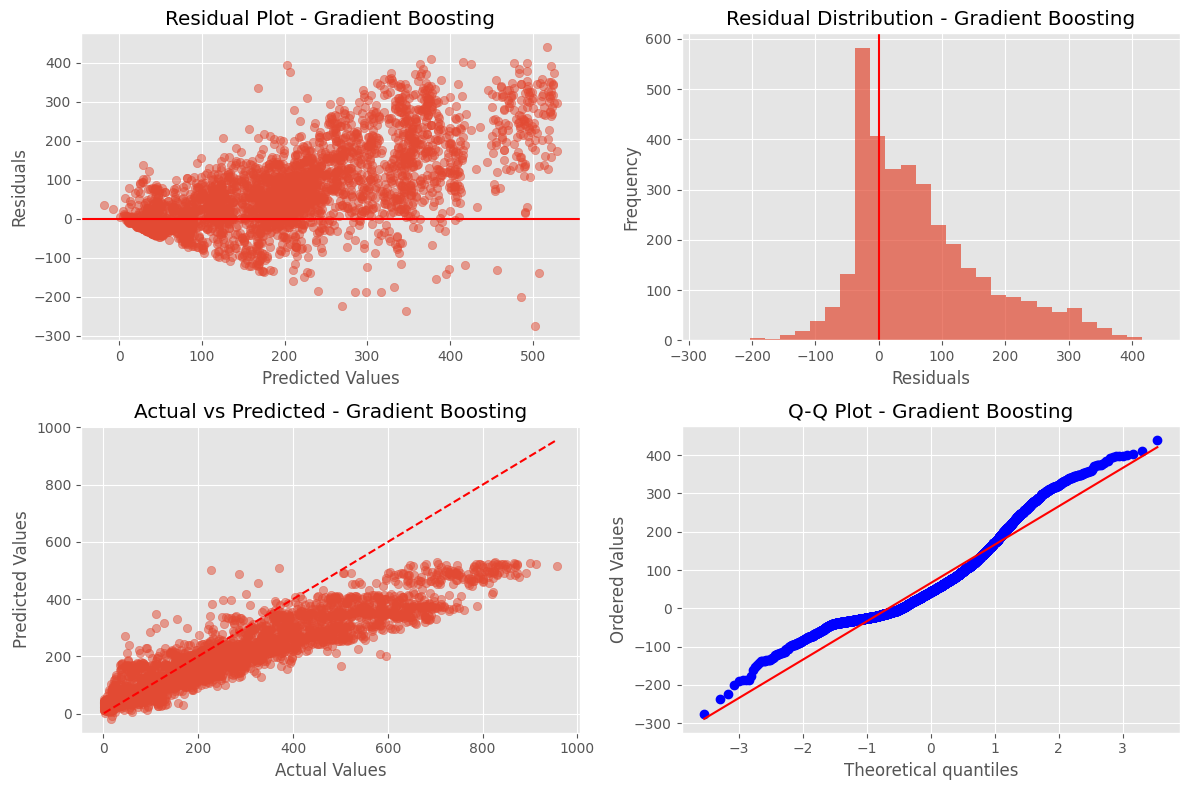

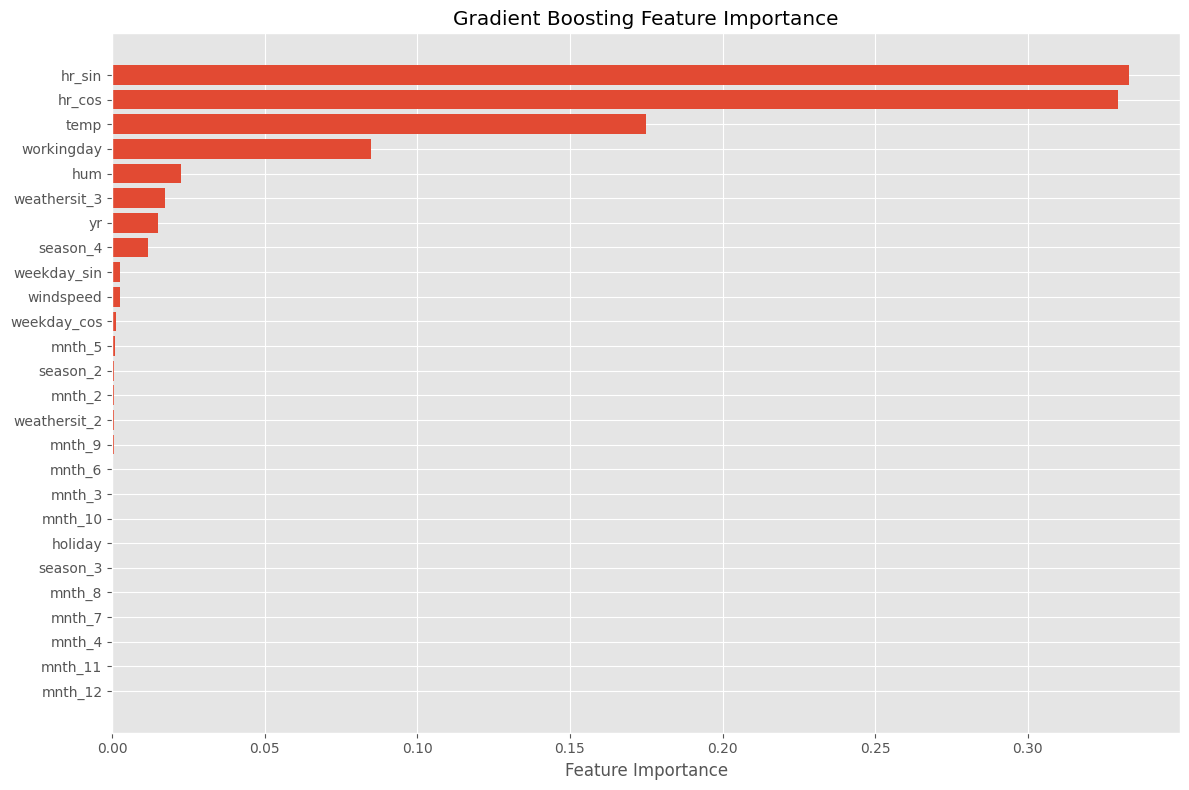

In [17]:

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions on validation set
y_val_pred_gb = gb_model.predict(X_val)
gb_mse = mean_squared_error(y_val, y_val_pred_gb)
gb_rmse = np.sqrt(gb_mse)
gb_mae = mean_absolute_error(y_val, y_val_pred_gb)
gb_r2 = r2_score(y_val, y_val_pred_gb)

# Make predictions on training set (overfit check)
y_train_pred_gb = gb_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred_gb)
train_r2 = r2_score(y_train, y_train_pred_gb)


print("\n===== Gradient Boosting Regressor Results =====")
print(f"Mean Squared Error (MSE): {gb_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {gb_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {gb_mae:.2f}")
print(f"R² Score: {gb_r2:.4f}\n")
print(f"Training MSE: {train_mse:.2f}, Validation MSE: {gb_mse:.2f}")
print(f"Training R²: {train_r2:.4f}, Validation R²: {gb_r2:.4f}")

if train_r2 - gb_r2 > 0.05:
    print("Warning: There are signs of overfitting - the model performs significantly better on training data than validation data.")
else:
    print("The model shows good generalization with similar performance on training and validation data.")

# Plot residuals
residuals_gb = y_val - y_val_pred_gb

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(y_val_pred_gb, residuals_gb, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - Gradient Boosting')

# Histogram of residuals
plt.subplot(2, 2, 2)
plt.hist(residuals_gb, bins=30, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='-')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution - Gradient Boosting')

# Actual vs Predicted
plt.subplot(2, 2, 3)
plt.scatter(y_val, y_val_pred_gb, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted - Gradient Boosting')

# QQ plot for residuals
plt.subplot(2, 2, 4)
stats.probplot(residuals_gb, dist="norm", plot=plt)
plt.title('Q-Q Plot - Gradient Boosting')

plt.tight_layout()
plt.show()

# Feature importance plot
feature_importance = gb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(12, 8))
plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Gradient Boosting Feature Importance')
plt.tight_layout()
plt.show()

This model actually performed the worst out of all three.

The values for MSE and RMSE, 15073 and 122 respectivley, show that the model poorly predicts the target feature. Also, it also has an R^2 score of 0.6692, worse than the other two models, meaning it does worse than just predicting the mean of 'cnt'.

Again, when checking for overfitting we can obviously tell that the model performs better on seen data, although not as much as Random Forests. It fails to generalize to the validation set, and performs better on its training set (R^2 value of 0.8683). This can be fixed with hyperparameter tuning (limiting tree depth, increasing min_samples_leaf, etc.), which will be done in task 7. 

The plot of residuals is very similar to that of the Random forest, it fans out in the positive direction telling us that the model is systematically underpredicting at higher values of 'cnt'. 

The distribution of residuals is again skewed right, impyling that the model underpredicts high-value targets. This distribution also looks very similar to that of the Random Forest. Although it isn't quite normally distributed, which isn't essential for Gradient Boosting although it is a sign of imbalance in the model's predictive capabilities, it does have much less of a right skew than with the Linear Regression model. 


There is virtually no change in the feature importance plot. The model again focused on the hour feature, along with temperature humidity and working day.


Again, to improve this model I could introduce an interaction term into the dataset. Although Gradient Boosting can capture these on its own, explicit interactions can still help in weakly informative features (like weather type and month). I will also tweak the hyperparameters to reduce overfitting, as well as try and address the heavy left-skew present in the target feature.

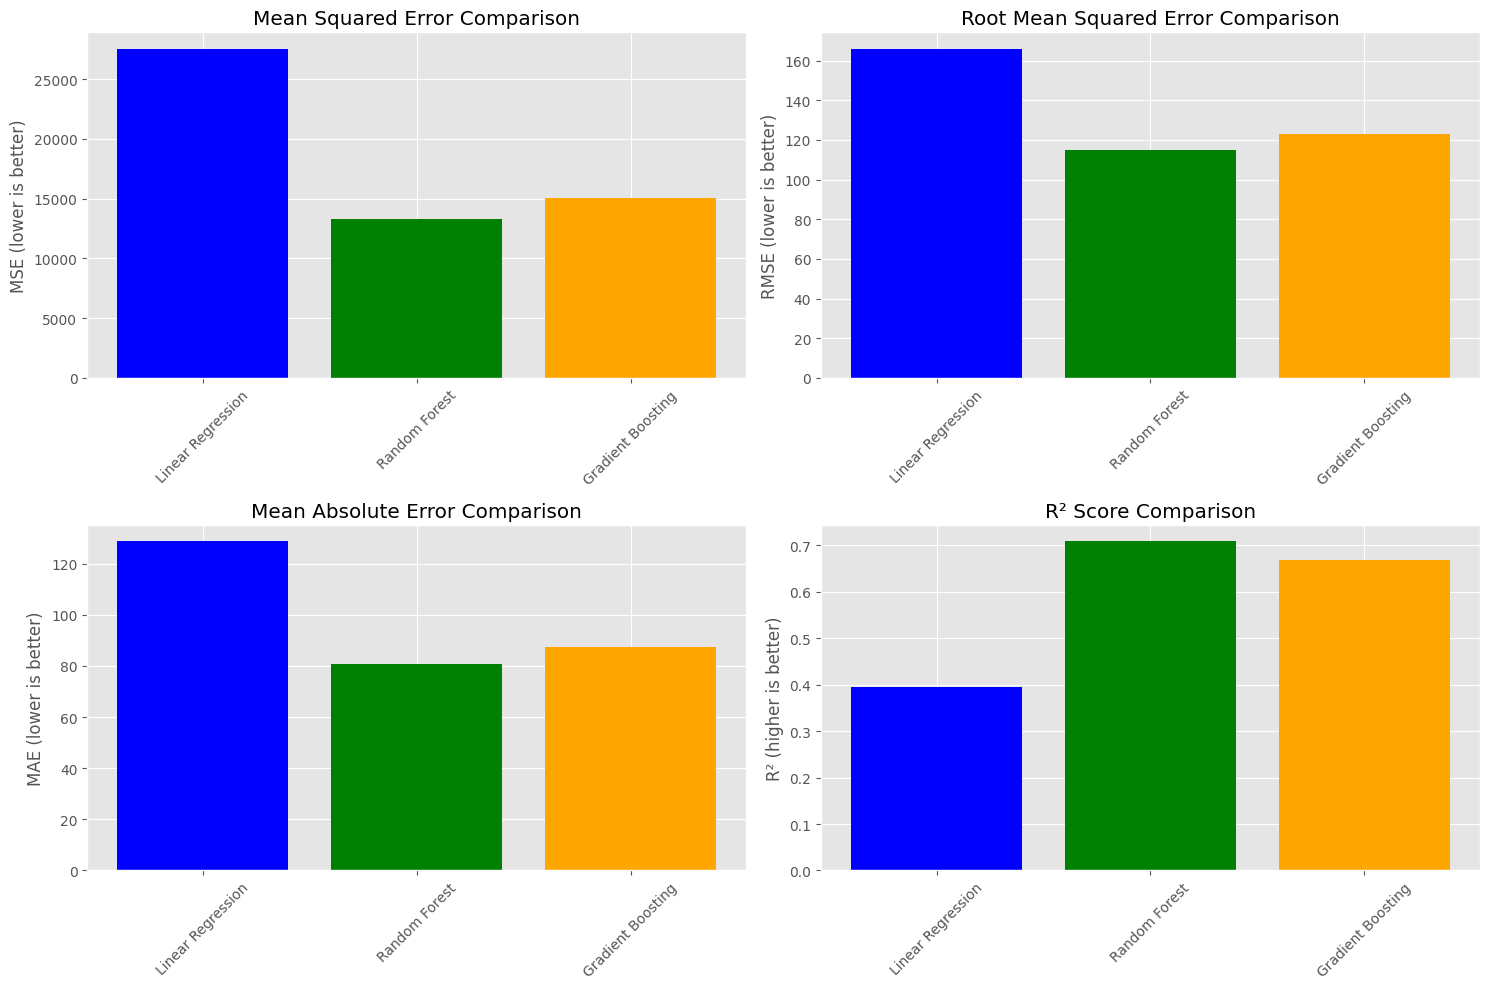

In [18]:
models = ['Linear Regression', 'Random Forest', 'Gradient Boosting']
mse_scores = [lr_mse, rf_mse, gb_mse]
rmse_scores = [lr_rmse, rf_rmse, gb_rmse]
mae_scores = [lr_mae, rf_mae, gb_mae]
r2_scores = [lr_r2, rf_r2, gb_r2]

plt.figure(figsize=(15, 10))

# MSE comparison
plt.subplot(2, 2, 1)
plt.bar(models, mse_scores, color=['blue', 'green', 'orange'])
plt.ylabel('MSE (lower is better)')
plt.title('Mean Squared Error Comparison')
plt.xticks(rotation=45)

# RMSE comparison
plt.subplot(2, 2, 2)
plt.bar(models, rmse_scores, color=['blue', 'green', 'orange'])
plt.ylabel('RMSE (lower is better)')
plt.title('Root Mean Squared Error Comparison')
plt.xticks(rotation=45)

# MAE comparison
plt.subplot(2, 2, 3)
plt.bar(models, mae_scores, color=['blue', 'green', 'orange'])
plt.ylabel('MAE (lower is better)')
plt.title('Mean Absolute Error Comparison')
plt.xticks(rotation=45)

# R² comparison
plt.subplot(2, 2, 4)
plt.bar(models, r2_scores, color=['blue', 'green', 'orange'])
plt.ylabel('R² (higher is better)')
plt.title('R² Score Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Task 8 Part 1: Iterative Evaluation and Refinement

Before I get started with Hyperparamter tuning, I want to first make some 'obvious' changes to my data to limit the amount of times I have to re-train the models.

Most importantly, I want to address the heavy right-skew in the target feature ('cnt'), as I pointed out in the EDA. I will try applying a log transformation on the target feature, which will stablize variance. It will compress high values and spread low ones, signifcantly helping regression models to generalize better.

In [19]:
y_train_log = np.log1p(y_train)  # log(1 + y)

# Now when I train regression models, I'll use y_train_log instead. Then I'll invert the predictions to get actual values, allowing me to compute the metrics

## Retraining all three

In [20]:
# LINEAR REGRESSION
lr_model = LinearRegression()
lr_model.fit(X_train, y_train_log)

y_val_pred_log = lr_model.predict(X_val)
y_val_pred_lr = np.expm1(y_val_pred_log)

lr_mse = mean_squared_error(y_val, y_val_pred_lr)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_val, y_val_pred_lr)
lr_r2 = r2_score(y_val, y_val_pred_lr)

print("\n===== Linear Regression Results =====")
print(f"Mean Squared Error (MSE): {lr_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {lr_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {lr_mae:.2f}")
print(f"R² Score: {lr_r2:.4f}")


# RANDOM FOREST
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_log)

y_val_pred_log = rf_model.predict(X_val)
y_val_pred_rf = np.expm1(y_val_pred_log)

rf_mse = mean_squared_error(y_val, y_val_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_val, y_val_pred_rf)
rf_r2 = r2_score(y_val, y_val_pred_rf)

# Overfit check; predict on training set
y_train_pred_log = rf_model.predict(X_train)
y_train_pred_rf = np.expm1(y_train_pred_log)
train_mse_rf = mean_squared_error(y_train, y_train_pred_rf)
train_r2_rf = r2_score(y_train, y_train_pred_rf)

print("\n===== Random Forest Regressor Results =====")
print(f"Mean Squared Error (MSE): {rf_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rf_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {rf_mae:.2f}")
print(f"R² Score: {rf_r2:.4f}\n")
print(f"Training MSE: {train_mse_rf:.2f}, Validation MSE: {rf_mse:.2f}")
print(f"Training R²: {train_r2_rf:.4f}, Validation R²: {rf_r2:.4f}")


# GRADIENT BOOSTING
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train_log)

y_val_pred_log = gb_model.predict(X_val)
y_val_pred_gb = np.expm1(y_val_pred_log)

gb_mse = mean_squared_error(y_val, y_val_pred_gb)
gb_rmse = np.sqrt(gb_mse)
gb_mae = mean_absolute_error(y_val, y_val_pred_gb)
gb_r2 = r2_score(y_val, y_val_pred_gb)

# Make predictions on training set (overfit check)
y_train_pred_gb_log = gb_model.predict(X_train)
y_train_pred_gb = np.expm1(y_train_pred_gb_log)
train_mse = mean_squared_error(y_train, y_train_pred_gb)
train_r2 = r2_score(y_train, y_train_pred_gb)

print("\n===== Gradient Boosting Regressor Results =====")
print(f"Mean Squared Error (MSE): {gb_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {gb_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {gb_mae:.2f}")
print(f"R² Score: {gb_r2:.4f}\n")
print(f"Training MSE: {train_mse:.2f}, Validation MSE: {gb_mse:.2f}")
print(f"Training R²: {train_r2:.4f}, Validation R²: {gb_r2:.4f}")


===== Linear Regression Results =====
Mean Squared Error (MSE): 57637.33
Root Mean Squared Error (RMSE): 240.08
Mean Absolute Error (MAE): 156.12
R² Score: -0.2650

===== Random Forest Regressor Results =====
Mean Squared Error (MSE): 14866.89
Root Mean Squared Error (RMSE): 121.93
Mean Absolute Error (MAE): 86.27
R² Score: 0.6737

Training MSE: 197.93, Validation MSE: 14866.89
Training R²: 0.9890, Validation R²: 0.6737

===== Gradient Boosting Regressor Results =====
Mean Squared Error (MSE): 14614.90
Root Mean Squared Error (RMSE): 120.89
Mean Absolute Error (MAE): 81.77
R² Score: 0.6792

Training MSE: 2799.40, Validation MSE: 14614.90
Training R²: 0.8439, Validation R²: 0.6792


The model doesn't perform much better, with almost no change in R^2 values (when comparing validation R^2 before and after the log transformation). If anything, it actually did worse

Because of this, I won't keep this change in and explore other ways to improve performance.

# Task 7: Hyperparameter Tuning

## Random Forest Tuning

For this I'm first gonna employ Randomized Search CV with 5-fold cross-validation to tune: n_estimators, max_depth, min_samples_split and min_samples_leaf.

Instead of manualy guessing values for the mentioned hyperparameters, RandomizedSearchCV tests many combinations randomly to find which performs best. Since we've already identified a pretty major overfitting problem with the Random Forest, its smart to use a 5-fold cross-validation to avoid this. This gives each hyperparmater 'guess' a more reliable estimate of how it would perform on unseen data.

Also, since we're using RandomizedSearchCV instead of GridSearchCV (which tries EVERY combination) its much quicker.

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Parameters for Random Forest:
n_estimators: 500
min_samples_split: 2
min_samples_leaf: 1
max_depth: 30
bootstrap: True

Random Forest Performance Comparison:
Metric    | Before Tuning | After Tuning | Improvement
MSE       | 14866.89         | 13278.82         | 1588.07 (10.68%)
RMSE      | 121.93         | 115.23         | 6.70 (5.49%)
MAE       | 86.27         | 80.98         | 5.29 (6.13%)
R² Score  | 0.6737      | 0.7086      | 0.0349 (5.17%)

Tuned Model Training vs Validation Performance:
Training MSE: 166.53, Validation MSE: 13278.82
Training R²: 0.9907, Validation R²: 0.7086


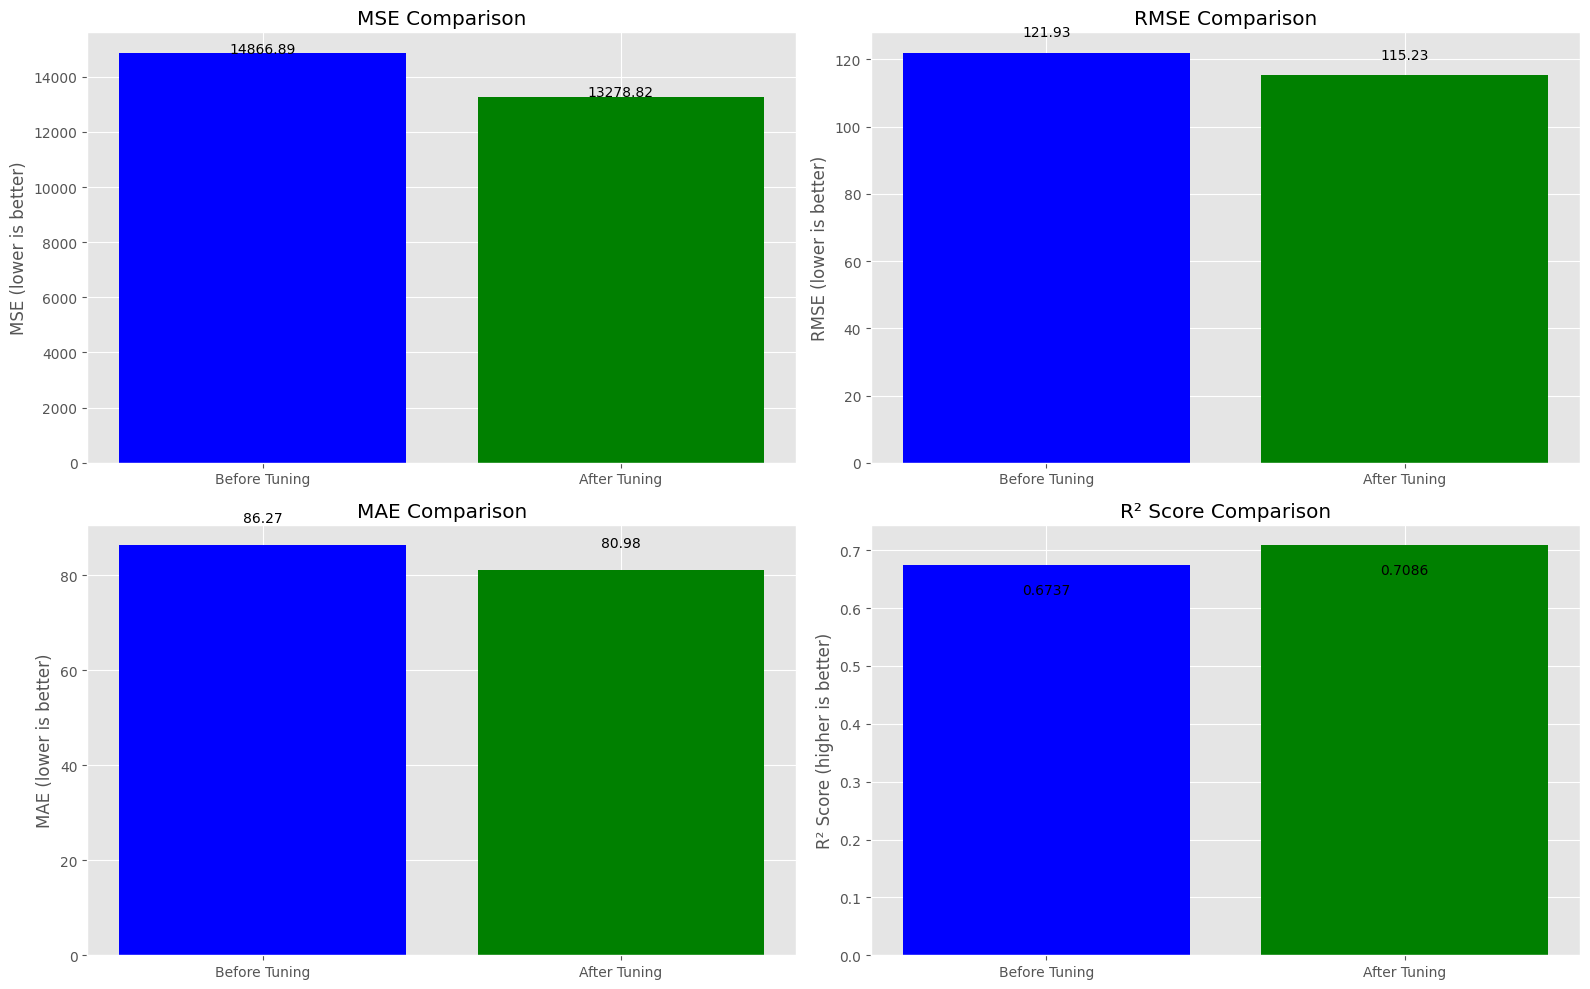

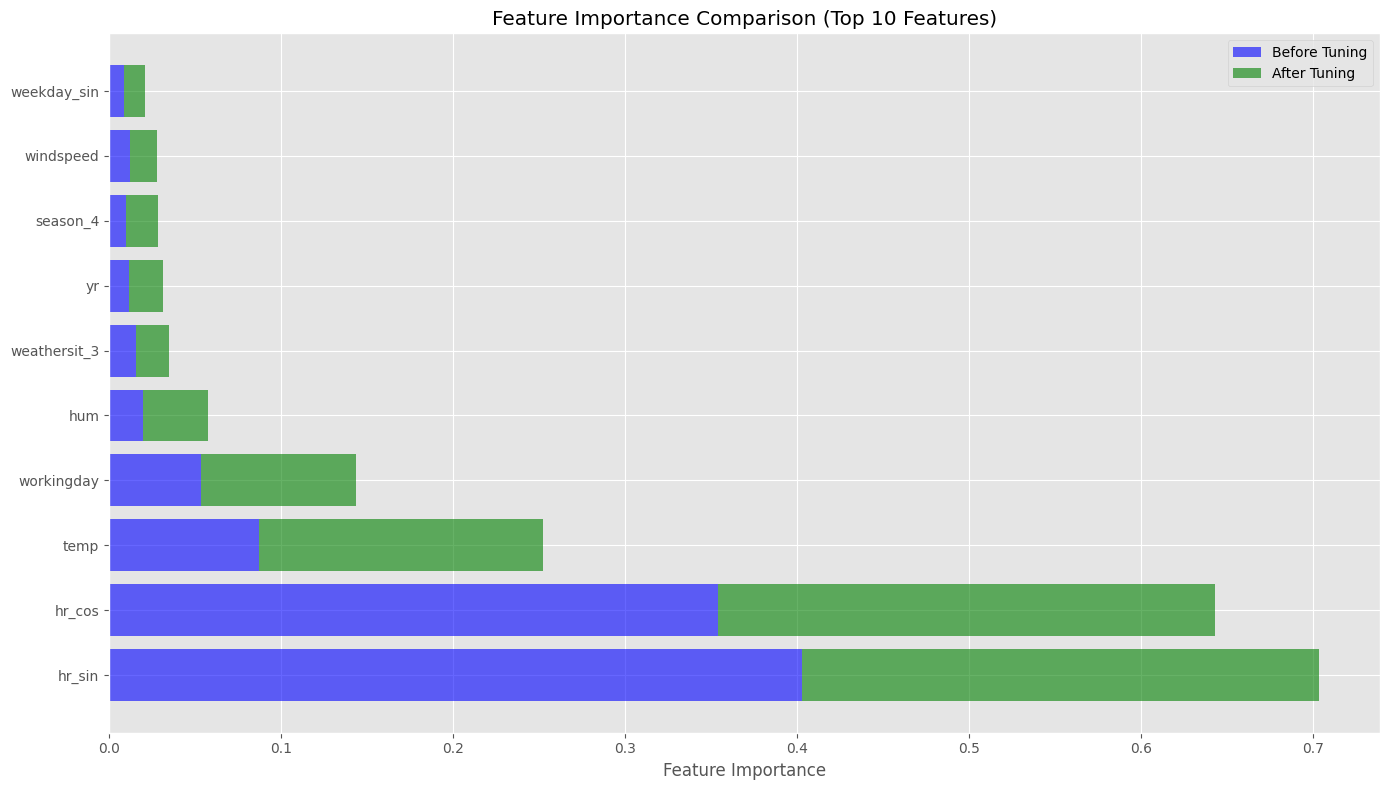

In [21]:
param_grid = {
    'n_estimators': [25, 50, 100, 250, 500],
    'max_depth': [5, 10, 15, 30, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
    'bootstrap': [True, False]
}

# Initialize the RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    cv=5,       # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)
rf_random.fit(X_train, y_train)

# Get the best parameters
best_params = rf_random.best_params_
print("\nBest Parameters for Random Forest:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Train a new model with the best parameters
rf_tuned = RandomForestRegressor(**best_params, random_state=42)
rf_tuned.fit(X_train, y_train)
y_val_pred_rf_tuned = rf_tuned.predict(X_val)

# Calculate metrics for the tuned model
rf_tuned_mse = mean_squared_error(y_val, y_val_pred_rf_tuned)
rf_tuned_rmse = np.sqrt(rf_tuned_mse)
rf_tuned_mae = mean_absolute_error(y_val, y_val_pred_rf_tuned)
rf_tuned_r2 = r2_score(y_val, y_val_pred_rf_tuned)


print("\nRandom Forest Performance Comparison:")
print(f"Metric    | Before Tuning | After Tuning | Improvement")
print(f"MSE       | {rf_mse:.2f}         | {rf_tuned_mse:.2f}         | {(rf_mse - rf_tuned_mse):.2f} ({((rf_mse - rf_tuned_mse) / rf_mse * 100):.2f}%)")
print(f"RMSE      | {rf_rmse:.2f}         | {rf_tuned_rmse:.2f}         | {(rf_rmse - rf_tuned_rmse):.2f} ({((rf_rmse - rf_tuned_rmse) / rf_rmse * 100):.2f}%)")
print(f"MAE       | {rf_mae:.2f}         | {rf_tuned_mae:.2f}         | {(rf_mae - rf_tuned_mae):.2f} ({((rf_mae - rf_tuned_mae) / rf_mae * 100):.2f}%)")
print(f"R² Score  | {rf_r2:.4f}      | {rf_tuned_r2:.4f}      | {(rf_tuned_r2 - rf_r2):.4f} ({((rf_tuned_r2 - rf_r2) / abs(rf_r2) * 100):.2f}%)")

# Overfit check
y_train_pred_rf_tuned = rf_tuned.predict(X_train)
train_mse_tuned = mean_squared_error(y_train, y_train_pred_rf_tuned)
train_r2_tuned = r2_score(y_train, y_train_pred_rf_tuned)

print(f"\nTuned Model Training vs Validation Performance:")
print(f"Training MSE: {train_mse_tuned:.2f}, Validation MSE: {rf_tuned_mse:.2f}")
print(f"Training R²: {train_r2_tuned:.4f}, Validation R²: {rf_tuned_r2:.4f}")
if train_r2_tuned - rf_tuned_r2 > 0.1:
    print("Warning: The tuned model may be overfitting. Consider regularization techniques.")
else:
    print("The tuned model shows good generalization capacity without severe overfitting.")


# Visualize the performance improvement
metrics = ['MSE', 'RMSE', 'MAE', 'R²']
before_tuning = [rf_mse, rf_rmse, rf_mae, rf_r2]
after_tuning = [rf_tuned_mse, rf_tuned_rmse, rf_tuned_mae, rf_tuned_r2]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

# For the error metrics
for i, (metric, before, after) in enumerate(zip(metrics[:3], before_tuning[:3], after_tuning[:3])):
    axes[i].bar(['Before Tuning', 'After Tuning'], [before, after], color=['blue', 'green'])
    axes[i].set_ylabel(f'{metric} (lower is better)')
    axes[i].set_title(f'{metric} Comparison')
    for j, v in enumerate([before, after]):
        axes[i].text(j, v + 5, f'{v:.2f}', ha='center')

# For R²
axes[3].bar(['Before Tuning', 'After Tuning'], [before_tuning[3], after_tuning[3]], color=['blue', 'green'])
axes[3].set_ylabel('R² Score (higher is better)')
axes[3].set_title('R² Score Comparison')
for j, v in enumerate([before_tuning[3], after_tuning[3]]):
    axes[3].text(j, v - 0.05, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

# Let's compare the feature importance before and after tuning
feature_importance_tuned = rf_tuned.feature_importances_
features = X_train.columns
indices = np.argsort(feature_importance_tuned)[::-1]
importance_comparison = pandas.DataFrame({
    'Feature': features,
    'Before Tuning': rf_model.feature_importances_,
    'After Tuning': rf_tuned.feature_importances_
})
# Sort by the average importance
importance_comparison['Average'] = (importance_comparison['Before Tuning'] + importance_comparison['After Tuning']) / 2
importance_comparison = importance_comparison.sort_values('Average', ascending=False).head(10)  # Top 10 features

plt.figure(figsize=(14, 8))
before_bars = plt.barh(importance_comparison['Feature'], importance_comparison['Before Tuning'], 
                       color='blue', alpha=0.6, label='Before Tuning')
after_bars = plt.barh(importance_comparison['Feature'], importance_comparison['After Tuning'], 
                      color='green', alpha=0.6, label='After Tuning', left=importance_comparison['Before Tuning'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Comparison (Top 10 Features)')
plt.legend()
plt.tight_layout()
plt.show()

After finding the best hyperparamter combination, using Randomized Search CV, we see a slight improvement in performance. There was a 10% imrprovement in MSE and about a 5% improvement in R^2. This is good, but still we see signs of overfitting.

The feature importance did change, however, with many of the same features increasing in importance. The hourly datapoints nearly doubled in importance, and temperature more than doubled.

## Gradient Boosting Tuning

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

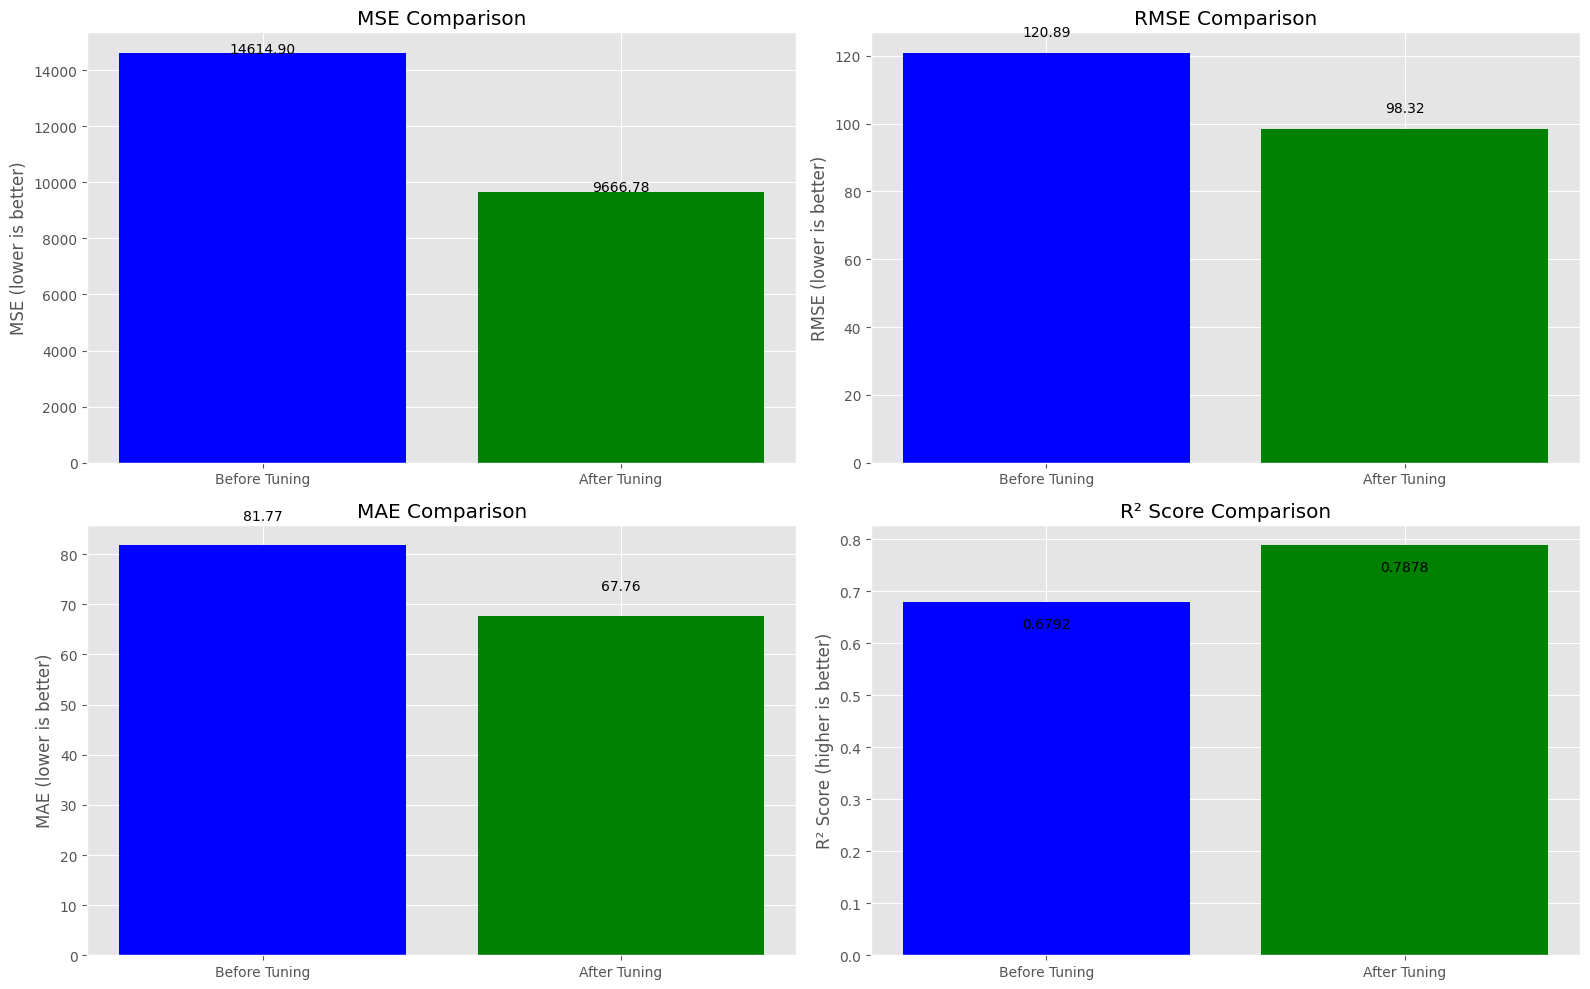

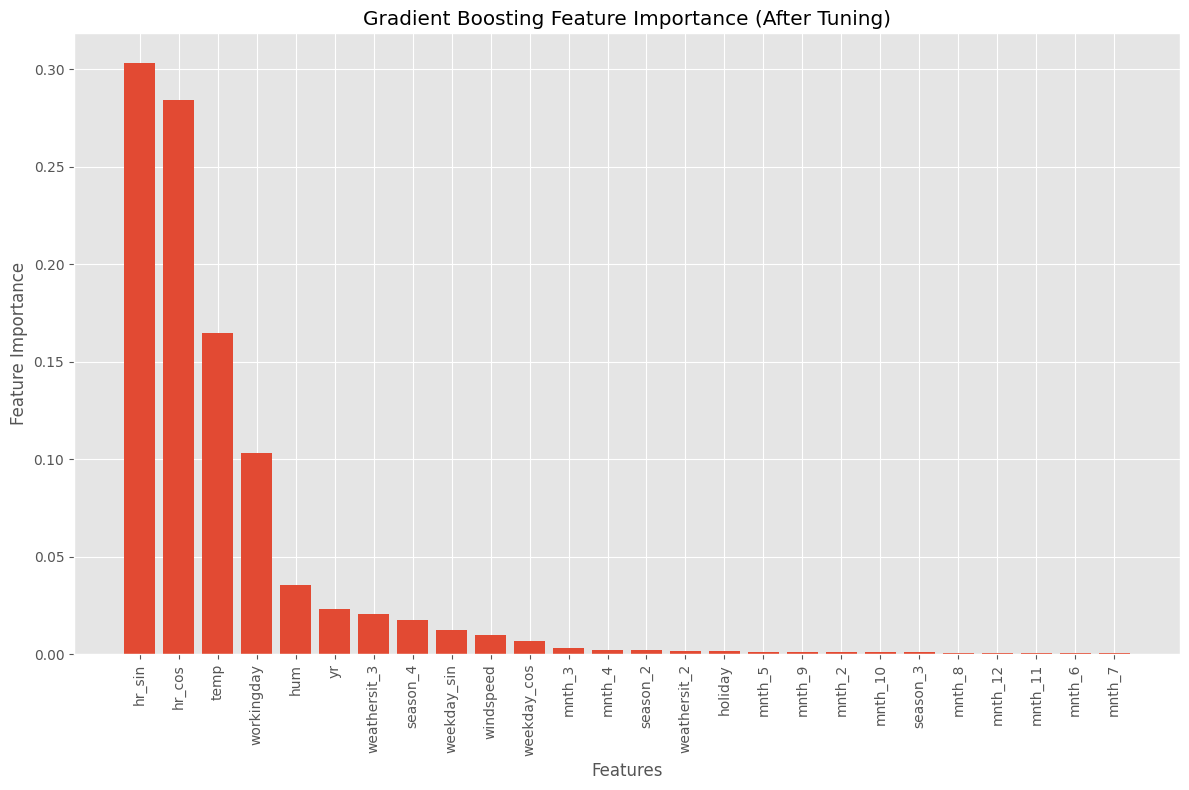

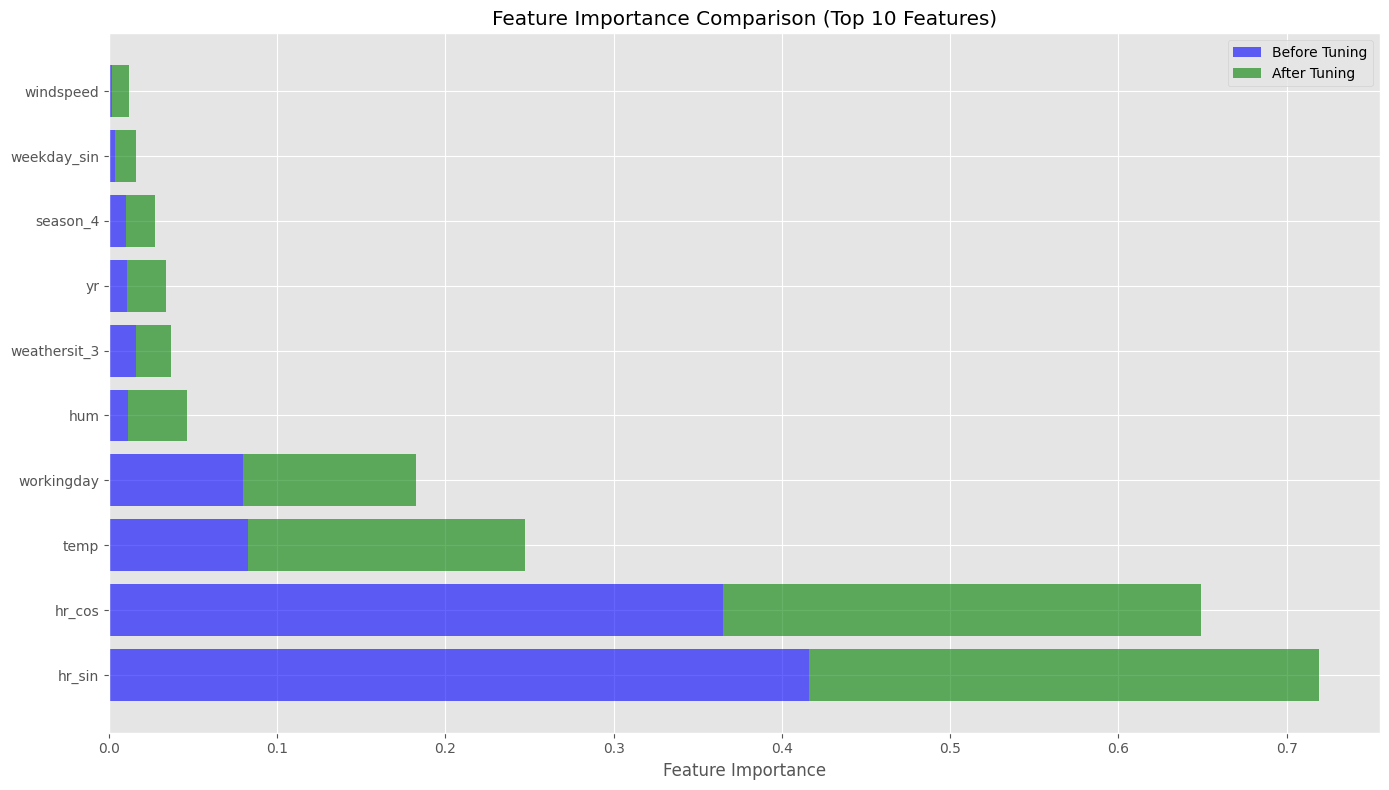

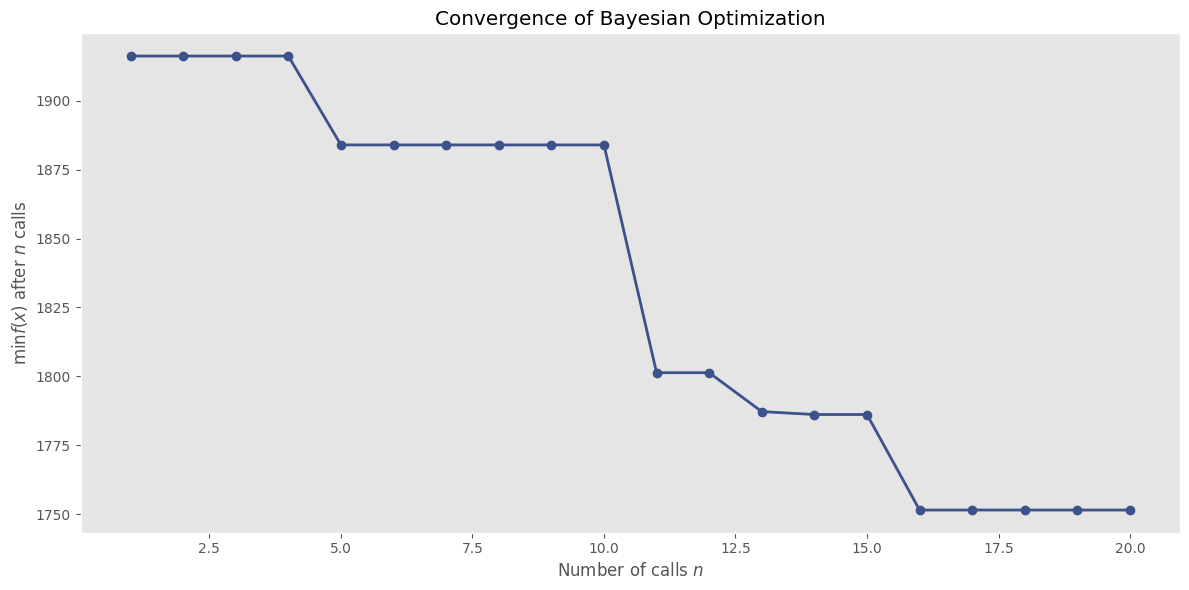

In [22]:
param_space = {
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(3, 15),
    'subsample': Real(0.5, 1.0),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10)
}

bayes_cv = BayesSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    search_spaces=param_space,
    n_iter=20,
    cv=5,        # 5-fold cross-validation
    n_jobs=-1,
    verbose=1,
    random_state=42,
    scoring='neg_mean_squared_error'
)

bayes_cv.fit(X_train, y_train)
best_params = bayes_cv.best_params_
print("\nBest Parameters for Gradient Boosting:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Train a new model with the best parameters
gb_tuned = GradientBoostingRegressor(**best_params, random_state=42)
gb_tuned.fit(X_train, y_train)

y_val_pred_gb_tuned = gb_tuned.predict(X_val)

gb_tuned_mse = mean_squared_error(y_val, y_val_pred_gb_tuned)
gb_tuned_rmse = np.sqrt(gb_tuned_mse)
gb_tuned_mae = mean_absolute_error(y_val, y_val_pred_gb_tuned)
gb_tuned_r2 = r2_score(y_val, y_val_pred_gb_tuned)

# Display the performance improvement
print("\nGradient Boosting Performance Comparison:")
print(f"Metric    | Before Tuning | After Tuning | Improvement")
print(f"MSE       | {gb_mse:.2f}         | {gb_tuned_mse:.2f}         | {(gb_mse - gb_tuned_mse):.2f} ({((gb_mse - gb_tuned_mse) / gb_mse * 100):.2f}%)")
print(f"RMSE      | {gb_rmse:.2f}         | {gb_tuned_rmse:.2f}         | {(gb_rmse - gb_tuned_rmse):.2f} ({((gb_rmse - gb_tuned_rmse) / gb_rmse * 100):.2f}%)")
print(f"MAE       | {gb_mae:.2f}         | {gb_tuned_mae:.2f}         | {(gb_mae - gb_tuned_mae):.2f} ({((gb_mae - gb_tuned_mae) / gb_mae * 100):.2f}%)")
print(f"R² Score  | {gb_r2:.4f}      | {gb_tuned_r2:.4f}      | {(gb_tuned_r2 - gb_r2):.4f} ({((gb_tuned_r2 - gb_r2) / abs(gb_r2) * 100):.2f}%)")

# Overfit check
y_train_pred_gb_tuned = gb_tuned.predict(X_train)
train_mse_tuned = mean_squared_error(y_train, y_train_pred_gb_tuned)
train_r2_tuned = r2_score(y_train, y_train_pred_gb_tuned)

print("\nTuned Gradient Boosting Model - Training vs Validation Performance:")
print(f"Training MSE: {train_mse_tuned:.2f}, Validation MSE: {gb_tuned_mse:.2f}")
print(f"Training R²: {train_r2_tuned:.4f}, Validation R²: {gb_tuned_r2:.4f}")

r2_gap = train_r2_tuned - gb_tuned_r2
mse_gap = gb_tuned_mse - train_mse_tuned
print(f"Generalization Gap (R²): {r2_gap:.4f}")
print(f"Generalization Gap (MSE): {mse_gap:.2f}")

if r2_gap > 0.1:
    print("Warning: The tuned model shows signs of overfitting. The training performance is significantly better than validation.")
else:
    print("The tuned model has good generalization capacity with a reasonable gap between training and validation performance.")


# Visualize the performance improvement
metrics = ['MSE', 'RMSE', 'MAE', 'R²']
before_tuning = [gb_mse, gb_rmse, gb_mae, gb_r2]
after_tuning = [gb_tuned_mse, gb_tuned_rmse, gb_tuned_mae, gb_tuned_r2]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, (metric, before, after) in enumerate(zip(metrics[:3], before_tuning[:3], after_tuning[:3])):
    axes[i].bar(['Before Tuning', 'After Tuning'], [before, after], color=['blue', 'green'])
    axes[i].set_ylabel(f'{metric} (lower is better)')
    axes[i].set_title(f'{metric} Comparison')
    for j, v in enumerate([before, after]):
        axes[i].text(j, v + 5, f'{v:.2f}', ha='center')

axes[3].bar(['Before Tuning', 'After Tuning'], [before_tuning[3], after_tuning[3]], color=['blue', 'green'])
axes[3].set_ylabel('R² Score (higher is better)')
axes[3].set_title('R² Score Comparison')
for j, v in enumerate([before_tuning[3], after_tuning[3]]):
    axes[3].text(j, v - 0.05, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()


feature_importance_tuned = gb_tuned.feature_importances_
features = X_train.columns
indices = np.argsort(feature_importance_tuned)[::-1]

plt.figure(figsize=(12, 8))
plt.bar(range(len(indices)), feature_importance_tuned[indices], align='center')
plt.xticks(range(len(indices)), [features[i] for i in indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Gradient Boosting Feature Importance (After Tuning)')
plt.tight_layout()
plt.show()

# Let's also show a comparison of feature importance before and after tuning
importance_comparison = pandas.DataFrame({
    'Feature': features,
    'Before Tuning': gb_model.feature_importances_,
    'After Tuning': gb_tuned.feature_importances_
})
importance_comparison['Average'] = (importance_comparison['Before Tuning'] + importance_comparison['After Tuning']) / 2
importance_comparison = importance_comparison.sort_values('Average', ascending=False).head(10)  # Top 10 features


plt.figure(figsize=(14, 8))
before_bars = plt.barh(importance_comparison['Feature'], importance_comparison['Before Tuning'], 
                       color='blue', alpha=0.6, label='Before Tuning')
after_bars = plt.barh(importance_comparison['Feature'], importance_comparison['After Tuning'], 
                      color='green', alpha=0.6, label='After Tuning', left=importance_comparison['Before Tuning'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Comparison (Top 10 Features)')
plt.legend()
plt.tight_layout()
plt.show()

# Visualize the convergence of the optimizer
plt.figure(figsize=(12, 6))
plot_convergence(bayes_cv.optimizer_results_)
plt.title('Convergence of Bayesian Optimization')
plt.tight_layout()
plt.show()


There is a much more signficant improvement in the performance of this model after tuining. MSE improved by 31% and R^2 by 14.66%, some pretty large changes. Still, however, there are signs of overfitting with a gap of 0.1738 in R^2 when testing it on the training data vs validation data. The convergence of the hyperparamter tuning took a while, which isn't great, but it was still able to flatten out by the end of it. This tells us that it found a good minimum and stabalized.

In [23]:
# Compare the tuned models (Random Forest vs Gradient Boosting)
print("\nComparison of Tuned Models:")
print(f"Metric    | Tuned Random Forest | Tuned Gradient Boosting")
print(f"MSE       | {rf_tuned_mse:.2f}              | {gb_tuned_mse:.2f}")
print(f"RMSE      | {rf_tuned_rmse:.2f}              | {gb_tuned_rmse:.2f}")
print(f"MAE       | {rf_tuned_mae:.2f}              | {gb_tuned_mae:.2f}")
print(f"R² Score  | {rf_tuned_r2:.4f}           | {gb_tuned_r2:.4f}")


Comparison of Tuned Models:
Metric    | Tuned Random Forest | Tuned Gradient Boosting
MSE       | 13278.82              | 9666.78
RMSE      | 115.23              | 98.32
MAE       | 80.98              | 67.76
R² Score  | 0.7086           | 0.7878


# Task 8 Part 2: Iterative Evaluation and Refinement

I'm going to add some custom flags to the temporal features in trying to make them for powerful.

In [24]:
# re initialize the data
data = pandas.read_csv("/Users/borisgans/IE/ML/assingments/assignment_2/bike+sharing+dataset/hour.csv")
data.drop(columns=['instant', 'dteday', 'casual', 'registered', 'atemp'], inplace=True)
pre_split_data = data.copy()

data_sorted = pre_split_data.sort_values(by=['yr', 'mnth', 'hr'])
n = len(data_sorted)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

# Split the data
train_data = data_sorted.iloc[:train_end]
val_data = data_sorted.iloc[train_end:val_end]
test_data = data_sorted.iloc[val_end:]

# Shuffle the monthly groups
train_data['month'] = train_data['mnth']
monthly_groups = train_data.groupby('month')
shuffled_train_data = monthly_groups.apply(lambda x: x.sample(frac=1)).reset_index(drop=True)


/var/folders/9s/vy9f4h3s1zx18jv8p3n1b6gh0000gn/T/ipykernel_67708/1638599821.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['month'] = train_data['mnth']


In [25]:
def add_custom_flags(df):
    # Weekend flag (Saturday is 6, Sunday is 0)
    df['is_weekend'] = df['weekday'].isin([0, 6]).astype(int)
    
    # Rush hour flag (7-9 AM and 4-7 PM)
    df['is_rush_hour'] = ((df['hr'] >= 7) & (df['hr'] <= 9) | 
                          (df['hr'] >= 16) & (df['hr'] <= 19)).astype(int)
    
    # Winter flag (months 11, 12, 1, 2)
    df['is_winter'] = df['mnth'].isin([11, 12, 1, 2]).astype(int)
    
    return df

# Apply flags to all datasets
shuffled_train_data = add_custom_flags(shuffled_train_data)
val_data = add_custom_flags(val_data)
test_data = add_custom_flags(test_data)

# Check the distribution of the new flags
print("\nFlag distribution in training data:")
for flag in ['is_weekend', 'is_rush_hour', 'is_winter']:
    counts = shuffled_train_data[flag].value_counts(normalize=True) * 100
    print(f"{flag}: {counts[1]:.1f}% True, {counts[0]:.1f}% False")


# Separate features and target
X_train = shuffled_train_data.drop(columns=['cnt', 'month'])
y_train = shuffled_train_data['cnt']

y_val = val_data['cnt']
X_val = val_data.drop(columns=['cnt'])

y_test = test_data['cnt']
X_test = test_data.drop(columns=['cnt'])
print(X_train.info())


Flag distribution in training data:
is_weekend: 28.8% True, 71.2% False
is_rush_hour: 29.3% True, 70.7% False
is_winter: 40.6% True, 59.4% False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10427 entries, 0 to 10426
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        10427 non-null  int64  
 1   yr            10427 non-null  int64  
 2   mnth          10427 non-null  int64  
 3   hr            10427 non-null  int64  
 4   holiday       10427 non-null  int64  
 5   weekday       10427 non-null  int64  
 6   workingday    10427 non-null  int64  
 7   weathersit    10427 non-null  int64  
 8   temp          10427 non-null  float64
 9   hum           10427 non-null  float64
 10  windspeed     10427 non-null  float64
 11  is_weekend    10427 non-null  int64  
 12  is_rush_hour  10427 non-null  int64  
 13  is_winter     10427 non-null  int64  
dtypes: float64(3), int64(11)
memory usage: 1.1 MB
None


/var/folders/9s/vy9f4h3s1zx18jv8p3n1b6gh0000gn/T/ipykernel_67708/2926541706.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_weekend'] = df['weekday'].isin([0, 6]).astype(int)
/var/folders/9s/vy9f4h3s1zx18jv8p3n1b6gh0000gn/T/ipykernel_67708/2926541706.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_rush_hour'] = ((df['hr'] >= 7) & (df['hr'] <= 9) |
/var/folders/9s/vy9f4h3s1zx18jv8p3n1b6gh0000gn/T/ipykernel_67708/2926541706.py:10: SettingWithCopyWarning: 
A value is trying to be set on a

# Task 9: Final Model Selection + Testing

After tuning Random Forests again, with the added features, our metrics are:
>- MSE: 11571 (22%)
>- RMSE: 107.57 (11.72%)
>- MAE: 75.23 (12.93%)
>- R^2: 0.7460
>- Generalization Gap (R^2): 0.071

After tuning Gradient Boosting again, our metrics are:
>- MSE: 9185 (37%)
>- RMSE: 95.84 (20.72%)
>- MAE: 65.30 (20.14%)
>- R^2: 0.7984
>- Generalization Gap: 0.1807

Considering these metrics, Im gonna use Gradient Boosting as the final model. It wins on all validation metrics, MSE, RMSE, MAE and R^2 on the validation set. In both models theres an obvious risk for overfitting, but its less the case in Gradient Boosting than with Random Forests. Random Forest has a training MSE of 162 but validation MSE of about 11k, a very large gap showing it has poor generalization. Gradient Boosting has a smaller gap, showing that its more suited to generalize over the testing data set.

Let's see how it does.

In [26]:
X_final_train = pandas.concat([X_train, X_val], axis=0)
y_final_train = pandas.concat([y_train, y_val], axis=0)


final_model = GradientBoostingRegressor(**best_params, random_state=42)
final_model.fit(X_final_train, y_final_train)

y_test_pred_final = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, y_test_pred_final)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test, y_test_pred_final)
final_r2 = r2_score(y_test, y_test_pred_final)

# Display results
print(f"Test MSE: {final_mse:.2f}")
print(f"Test RMSE: {final_rmse:.2f}")
print(f"Test MAE: {final_mae:.2f}")
print(f"Test R²: {final_r2:.4f}")

Test MSE: 4107.06
Test RMSE: 64.09
Test MAE: 41.89
Test R²: 0.9156


As we can see, our model performed well on our testing set. We got a R^2 value of 0.91, close enough to perfect, especially after all the negative values I was getting before I realized I forgot to shuffle the y_train dataset 

In my opinion, GradientBoosting performed the best because unlike Random Forest (which builds trees independently), Gradient Boosting builds trees sequentially, each one learning from the mistakes of the last. This focused correction often leads to better bias-variance tradeoffs. Gradient Boosting also allows control over more hyperparamters such as learning rate, tree depth, and number of estimators, making it easier to prevent overfitting and improve generalization. It handles non-linear relationships way better than Linear Regression (obviously) and often better than Random Forest by combining many shallow trees focused on residuals.